In [34]:
import os
import numpy as np
import pandas as pd
from sklearn import datasets
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import silhouette_score as silscore
from sklearn import preprocessing
import matplotlib.pyplot as plt
from itertools import combinations
from matplotlib.colors import ListedColormap
import seaborn as sns
from ExKMC.Tree import Tree as ExTree
from mdlp.discretization import MDLP
from intercluster import *
from intercluster.decision_trees import *
from intercluster.decision_sets import *
from intercluster.mining import *
from intercluster.pruning import *
from intercluster.experiments import *
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# NOTE: The following is important for recreating results, 
# But can be changed for randomized analysis.
seed = 170
np.random.seed(seed)

In [3]:
palette = sns.color_palette("husl", 8)
cmap = ListedColormap(palette)

color_dict = {i: cmap(7 - i) for i in range(8)}
color_dict[-1] = 'grey'

cmap2 = ListedColormap(sns.color_palette("tab20", 20))
color_dict2 = {i: cmap2(i) for i in range(len(cmap2.colors))}
color_dict2[-1] = 'grey'

# This assumes tex is installed in your system, 
# if not, you may simply remove most of this, aside from font.size 
# (doing so, however, will break certain plotting functions)
plt.rcParams.update({
    "pgf.texsystem": "pdflatex",
    "font.family": "serif",
    "font.serif": [],
    "text.usetex": True,
    "pgf.rcfonts": False,
    "font.size": 20
})

In [4]:
n_samples = 500
seed = 30

# ============
# Toy datasets from sci-kit learn's clustering examples:
# https://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html
# ============

# Circles
noisy_circles = datasets.make_circles(
    n_samples=n_samples, factor=0.5, noise=0.05, random_state=seed
)

# Moons
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=0.05, random_state=seed)

# Blobs
blobs = datasets.make_blobs(n_samples=n_samples, random_state=seed)

# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(
    n_samples=n_samples, cluster_std=[1.0, 2.5, 0.5], random_state=random_state
)

## Aniso

In [7]:
data,labels = aniso
k = 3
true_assignment = labels_to_assignment(labels_format(labels), k)

n_core = 5
density_distances = density_distance(data, n_core = n_core)
epsilon = min_inter_cluster_distance(density_distances, true_assignment) - 0.01
n_rules = 5


# DBSCAN
dbscan = DBSCAN(eps=epsilon, min_samples=n_core)
dbscan.fit(data)
# NOTE: this is dbscan*, where all non-core points are outliers
dbscan_labels_ = [label if i in dbscan.core_sample_indices_ else -1 for i,label in enumerate(dbscan.labels_)]
dbscan_labels = labels_format(dbscan_labels_)
dbscan_n_clusters = len(unique_labels(dbscan_labels, ignore = {-1}))
dbscan_assignment = labels_to_assignment(dbscan_labels, n_labels = dbscan_n_clusters, ignore = {-1})


# Decision Tree
dtree = DecisionTree(
    max_leaf_nodes = n_rules
)
dtree.fit(data, dbscan_labels)
dtree_labels = dtree.predict(data)
dtree_labels_ = flatten_labels(dtree_labels)
dtree_leaf_labels = dtree.get_leaf_labels()
# This should ignore any rules which are assigned to the outlier class 
dtree_rule_assignment = labels_to_assignment(dtree_leaf_labels, n_labels = dbscan_n_clusters, ignore = {-1})
dtree_data_to_rule_assignment = dtree.get_data_to_rules_assignment(data)
dtree_data_to_cluster_assignment = dtree_data_to_rule_assignment @ dtree_rule_assignment


# Removal Tree
rem_tree = RemovalTree(num_clusters = len(np.unique(dbscan_labels_)))
rem_tree.fit(data, dbscan_labels)
rem_tree_labels = rem_tree.predict(data, remove_outliers = False)
rem_tree_labels_ = flatten_labels(rem_tree_labels)
rem_tree_leaf_labels = rem_tree.get_leaf_labels()
# This should ignore any rules which are assigned to the outlier class 
rem_tree_rule_assignment = labels_to_assignment(rem_tree_leaf_labels, n_labels = dbscan_n_clusters, ignore = {-1})
rem_tree_data_to_rule_assignment = rem_tree.get_data_to_rules_assignment(data)
rem_tree_data_to_cluster_assignment = rem_tree_data_to_rule_assignment @ rem_tree_rule_assignment


# Decision Set Clustering
pointwise_miner = PointwiseMinerV2(samples = 10, prob_dim = 1/2, prob_mistake = 0.0)
#association_miner = AssociationRuleMiner(max_rules = 100, bin_type = 'mdlp')
dsclust = DSCluster(lambd = 1e6, n_rules = n_rules, rule_miner = pointwise_miner)
dsclust.fit(data, dbscan_labels)
dsclust_labels = dsclust.predict(data)
dsclust_labels_ = flatten_labels(dsclust_labels)
# This should ignore any rules which are assigned to the outlier class, but note that we already preventing outlier rules 
# in the DSCluster algorithm. This is here mostly for consistency.
dsclust_rule_assignment = labels_to_assignment(dsclust.decision_set_labels, n_labels = dbscan_n_clusters, ignore = {-1})
dsclust_data_to_rule_assignment = dsclust.get_data_to_rules_assignment(data)
dsclust_data_to_cluster_assignment = dsclust_data_to_rule_assignment @ dsclust_rule_assignment 

In [8]:
n_mine = 20
association_rule_miner = AssociationRuleMiner(max_rules = n_mine, bin_type = 'mdlp')

lambdas = [
    1/n_mine,
    1/(2 * data.shape[1] * n_mine),
    1/(len(data) * (n_mine**2)),
    1/(len(data) * (n_mine**2)),
    0,
    1/(data.shape[0] * n_mine),
    1/(data.shape[0])
]

ids_set = IdsSet(
    lambdas = lambdas,
    rule_miner = association_rule_miner
)
ids_set.fit(data, dbscan_labels)
ids_set_labels = ids_set.predict(data)
#ids_set_labels_ = flatten_labels(ids_set_labels)
ids_set_labels_ = np.array([min(labs) for labs in ids_set_labels])
ids_set_rule_assignment = labels_to_assignment(ids_set.decision_set_labels, n_labels = dbscan_n_clusters, ignore = {-1})
ids_set_data_to_rule_assignment = ids_set.get_data_to_rules_assignment(data)
ids_set_data_to_cluster_assignment = ids_set_data_to_rule_assignment @ ids_set_rule_assignment

Lambdas found: [0.05, 0.0125, 5e-06, 5e-06, 0, 0.0001, 0.002]


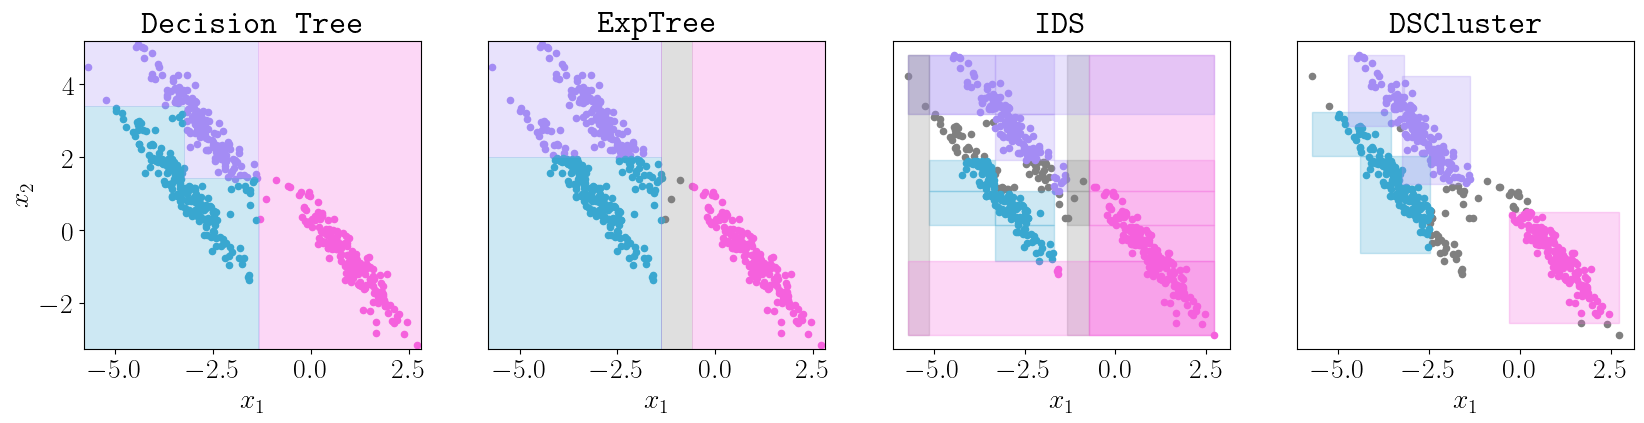

In [9]:
fig,axs = plt.subplots(nrows = 1, ncols = 4, figsize = (20,4), dpi = 100)

# DBSCAN
'''
uniqie_labs = np.unique(dbscan_labels_)
for l in uniqie_labs:
    idx = np.where(dbscan_labels_ == l)[0]
    axs[0].scatter(data[idx,0], data[idx,1], color = color_dict[l], s = 20)

axs[0].set_xlabel('x')
axs[0].set_ylabel('y')
axs[0].set_title(r"\texttt{DBSCAN}")
'''


# Decision Tree
uniqie_labs = np.unique(rem_tree_labels_)
for l in uniqie_labs:
    idx = np.where(dtree_labels_ == l)[0]
    axs[0].scatter(data[idx,0], data[idx,1], color = color_dict[l], s = 20)
plot_decision_boundaries(dtree, data, color_dict, ax = axs[0], resolution = 1000, label_array = False)
axs[0].set_xlabel(r'$x_1$')
axs[0].set_title(r"\texttt{Decision Tree}")


# Removal Tree
uniqie_labs = np.unique(rem_tree_labels_)
for l in uniqie_labs:
    idx = np.where(rem_tree_labels_ == l)[0]
    axs[1].scatter(data[idx,0], data[idx,1], color = color_dict[l], s = 20)
plot_decision_boundaries(rem_tree, data, color_dict, ax = axs[1], resolution = 1000, label_array = False)
axs[1].set_xlabel(r'$x_1$')
axs[1].set_title(r"\texttt{ExpTree}")

# IDS
uniqie_labs = np.unique(ids_set_labels_)
for l in uniqie_labs:
    idx = np.where(ids_set_labels_ == l)[0]
    axs[2].scatter(data[idx,0], data[idx,1], color = color_dict[l], s = 20)
plot_rule_boxes(ids_set, data, color_dict, axs[2])
axs[2].set_xlabel(r'$x_1$')
axs[2].set_title(r"\texttt{IDS}")


# Decision Set Clustering
uniqie_labs = np.unique(dsclust_labels_)
for l in uniqie_labs:
    idx = np.where(dsclust_labels_ == l)[0]
    axs[3].scatter(data[idx,0], data[idx,1], color = color_dict[l], s = 20)
plot_rule_boxes(dsclust, data, color_dict, axs[3])
axs[3].set_xlabel(r'$x_1$')
axs[3].set_title(r"\texttt{DSCluster}")

axs[0].set_ylabel(r'$x_2$')
axs[1].yaxis.set_visible(False)
axs[2].yaxis.set_visible(False)
axs[3].yaxis.set_visible(False)
#axs[4].yaxis.set_visible(False)

plt.savefig("../figures/examples/density_example.png", bbox_inches = 'tight', dpi = 300)

Error in callback <function _draw_all_if_interactive at 0x157f3a9d0> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

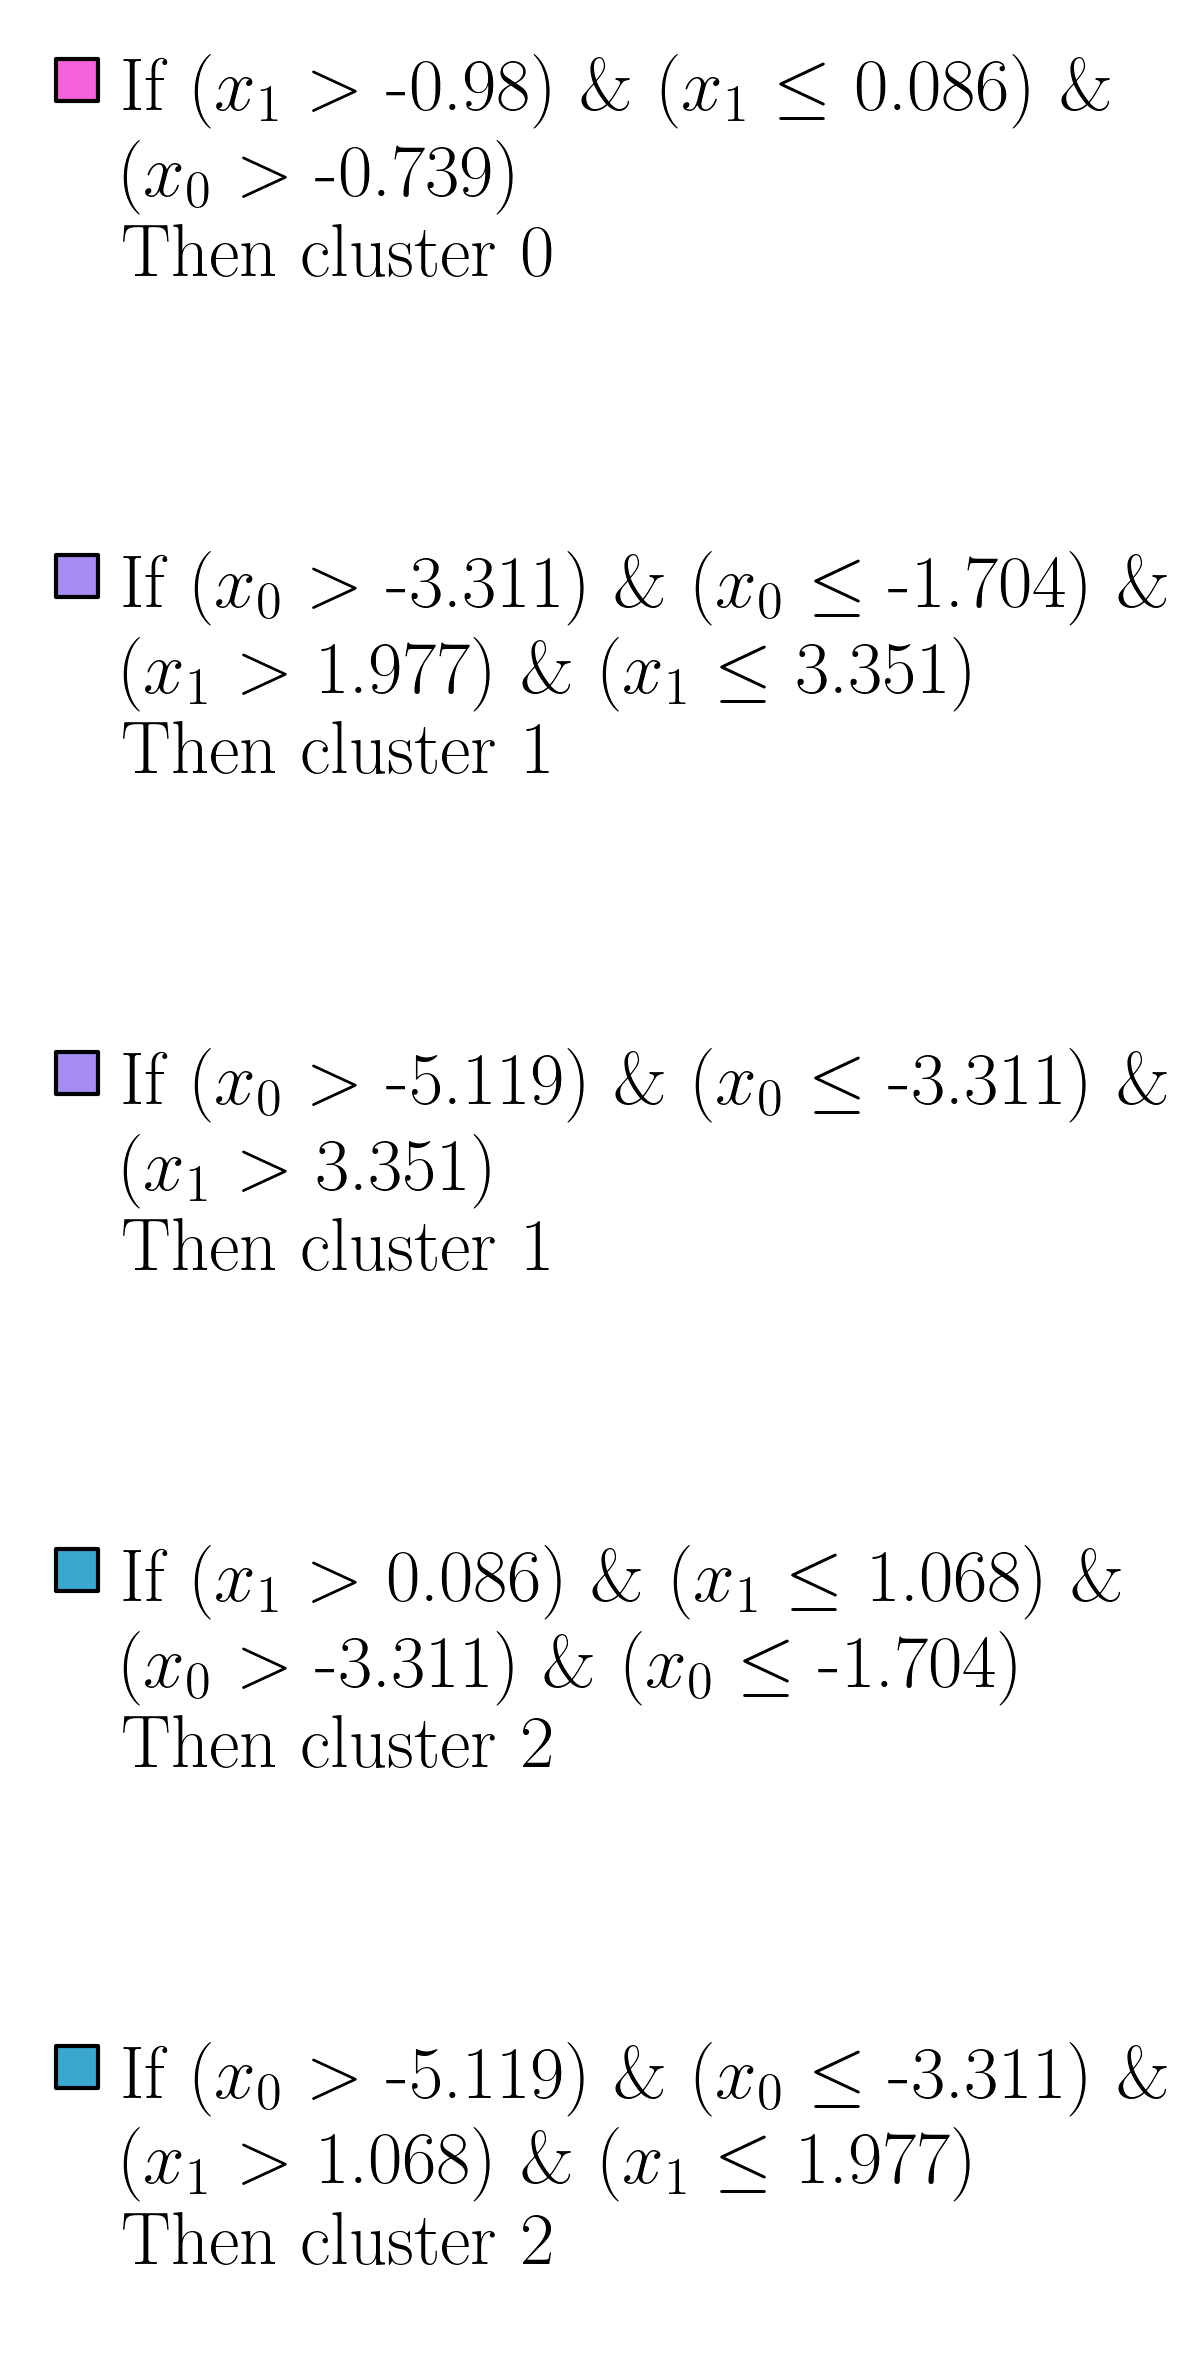

In [12]:
plot_decision_set(dsclust.decision_set, dsclust.decision_set_labels, color_dict = color_dict)

In [ ]:
########################################################################################
# Setup
seed = 342
np.random.seed(seed)

data, labels = aniso
k = 3
true_assignment = labels_to_assignment(labels_format(labels), k)

n_core = 5
density_distances = density_distance(data, n_core = n_core)
epsilon = min_inter_cluster_distance(density_distances, true_assignment) - 0.01
euclidean_distances = pairwise_distances(data)
lambda_val = 10

min_rules = 4
max_rules = 20

########################################################################################
# Baseline DBSCAN
dbscan_base = DBSCANBase(eps=epsilon, n_core=n_core)
dbscan_assignment = dbscan_base.assign(data)

# Decision Tree
decision_tree_params = {}
decision_tree_mod = DecisionTreeMod(
    model = DecisionTree,
    fitting_params = decision_tree_params,
    min_rules = min_rules,
    name = 'Decision-Tree'
)

# Removal Tree
rem_tree_params = {'num_clusters' : len(unique_labels(dbscan_base.labels))}
rem_tree_mod = DecisionTreeMod(
    model = RemovalTree,
    fitting_params = rem_tree_params,
    min_rules = min_rules,
    name = 'Removal-Tree'
)

# Decision Set Clustering
dsclust_params = {'lambd' : lambda_val, 'n_features' : 2, 'rules_per_point' : 3}
dsclust_mod = DecisionSetMod(
    model = DSCluster,
    fitting_params = dsclust_params,
    min_rules = min_rules,
    name = 'Decision-Set-Clustering'
)

# Baseline KMeans
kmeans_base = KMeansBase(n_clusters = 4)
kmeans_assignment = kmeans_base.assign(data)

# ExKMC
exkmc_params = {'k' : 4, 'kmeans': kmeans_base.clustering}
exkmc_mod = DecisionTreeMod(
    model = ExkmcTree,
    fitting_params = exkmc_params,
    min_rules = min_rules,
    name = 'ExKMC'
)



#######################################################################################

coverage_mistake_measure = CoverageMistakeScore(
    lambda_val = lambda_val,
    ground_truth_assignment = dbscan_assignment
)

silhouette_measure = Silhouette(
    distances = density_distances
)

coverage_mistake_measure1 = CoverageMistakeScore(
    lambda_val = lambda_val,
    ground_truth_assignment = kmeans_assignment,
    name = 'Coverage-Mistake-Score-KMeans'
)

silhouette_measure1 = Silhouette(
    distances = euclidean_distances,
    name = 'Silhouette-Score-Euclidean'
)


measurement_fns = [
    coverage_mistake_measure,
    silhouette_measure
]

########################################################################################

exp = MaxRulesExperiment(
    data = data,
    baseline = dbscan_base,
    module_list = [decision_tree_mod, rem_tree_mod, dsclust_mod],
    measurement_fns = measurement_fns,
    n_samples = 10,
    cpu_count = 1
)

exp_df = exp.run(n_steps = max_rules - min_rules)

In [ ]:
exp_df

In [ ]:
plot_df = exp_df.T.groupby(level=[0,1,2]).mean().T
plot_std_df = exp_df.T.groupby(level=[0,1,2]).std().T
rule_domain = np.arange(2,20)

fig,axs = plt.subplots(nrows = 1, ncols = 3, figsize = (20,4), dpi = 100)

subplot_df = plot_df.loc[:,'Coverage-Mistake-Score']
subplot_std_df = plot_std_df.loc[:,'Coverage-Mistake-Score']
axs[0].plot(rule_domain, subplot_df.loc[:,'DBSCAN'], linewidth = 3, label = 'DBSCAN', color = 'k', alpha = 0.25)
axs[0].plot(rule_domain, subplot_df.loc[:,'Decision-Tree'], linewidth = 3, label = 'Decision Tree', color = cmap(5))
axs[0].plot(rule_domain, subplot_df.loc[:,'Removal-Tree'], linewidth = 3, label = 'Removal Tree', linestyle = '--', color = 'k', alpha = 0.25)
axs[0].plot(rule_domain, subplot_df.loc[:,'Decision-Set-Clustering'], linewidth = 3, label = 'DSCluster', color = cmap(3))
axs[0].fill_between(
    rule_domain, 
    (subplot_df.loc[:,'Decision-Set-Clustering'] - subplot_std_df.loc[:,'Decision-Set-Clustering']).iloc[:,0],
    (subplot_df.loc[:,'Decision-Set-Clustering'] + subplot_std_df.loc[:,'Decision-Set-Clustering']).iloc[:,0],
    color= cmap(3),
    alpha=0.3
)
axs[0].set_xlabel('Max Rules')
axs[0].set_ylabel('Objective')



subplot_df = plot_df.loc[:,'Silhouette']
subplot_std_df = plot_std_df.loc[:,'Silhouette']
axs[1].plot(rule_domain, subplot_df.loc[:,'DBSCAN'], linewidth = 3, label = 'DBSCAN', color = 'k', alpha = 0.25)
axs[1].plot(rule_domain, subplot_df.loc[:,'Decision-Tree'], linewidth = 3, label = 'Decision Tree', color = cmap(5))
axs[1].plot(rule_domain, subplot_df.loc[:,'Removal-Tree'], linewidth = 3, label = 'Removal Tree', linestyle = '--', color = 'k', alpha = 0.25)
axs[1].plot(rule_domain, subplot_df.loc[:,'Decision-Set-Clustering'], linewidth = 3, label = 'DSCluster', color = cmap(3))
axs[1].fill_between(
    rule_domain, 
    (subplot_df.loc[:,'Decision-Set-Clustering'] - subplot_std_df.loc[:,'Decision-Set-Clustering']).iloc[:,0],
    (subplot_df.loc[:,'Decision-Set-Clustering'] + subplot_std_df.loc[:,'Decision-Set-Clustering']).iloc[:,0],
    color= cmap(3),
    alpha=0.3
)
axs[1].set_xlabel('Max Rules')
axs[1].set_ylabel('Silhouette Score')

subplot_df = plot_df.loc[:,'weighted-average-rule-length']
subplot_std_df = plot_std_df.loc[:,'weighted-average-rule-length']
axs[2].plot(rule_domain, subplot_df.loc[:,'DBSCAN'], linewidth = 3, label = 'DBSCAN', color = 'k', alpha = 0.25)
axs[2].plot(rule_domain, subplot_df.loc[:,'Decision-Tree'], linewidth = 3, label = 'Decision Tree', color = cmap(5))
axs[2].plot(rule_domain, subplot_df.loc[:,'Removal-Tree'], linewidth = 3, label = 'Removal Tree', linestyle = '--', color = 'k', alpha = 0.25)
axs[2].plot(rule_domain, subplot_df.loc[:,'Decision-Set-Clustering'], linewidth = 3, label = 'DSCluster', color = cmap(3))
axs[2].fill_between(
    rule_domain, 
    (subplot_df.loc[:,'Decision-Set-Clustering'] - subplot_std_df.loc[:,'Decision-Set-Clustering']).iloc[:,0],
    (subplot_df.loc[:,'Decision-Set-Clustering'] + subplot_std_df.loc[:,'Decision-Set-Clustering']).iloc[:,0],
    color= cmap(3),
    alpha=0.3
)
axs[2].set_xlabel('Max Rules')
axs[2].set_ylabel('Weighted Average Rule Length')

plt.legend(ncols = 4, bbox_to_anchor=(0.25, -0.25))



## Digits

In [10]:
data, data_labels_, feature_labels, scaler = load_preprocessed_digits()
data_labels = labels_format(data_labels_)
data = data
data_labels = data_labels
n,d = data.shape
n_unique_labels = len(unique_labels(data_labels))

In [11]:
data.shape

(1797, 64)

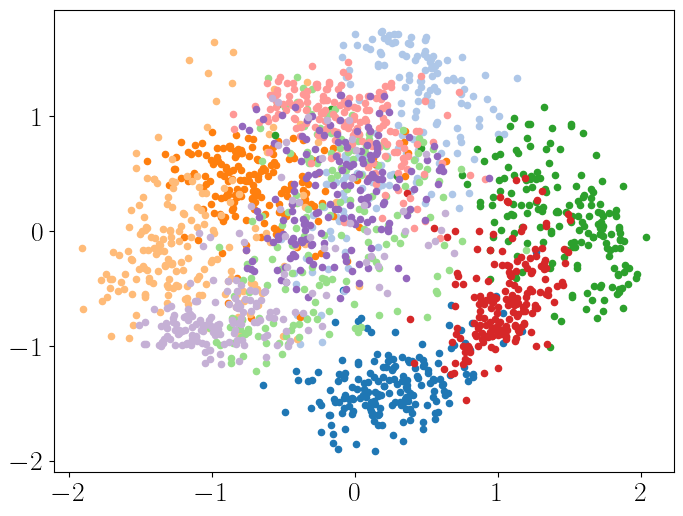

In [12]:
# PCA for visualization
pca = PCA(n_components=2)
data_2d = pca.fit_transform(data)

fig,ax = plt.subplots(figsize = (8,6))
uniqie_labs = np.unique(data_labels_)
for l in uniqie_labs:
    idx = np.where(data_labels_ == l)[0]
    ax.scatter(data_2d[idx,0], data_2d[idx,1], color = color_dict2[l], s = 20)

In [35]:
np.random.seed(seed)

In [13]:
# DBSCAN 
n_core = 20
true_assignment = labels_to_assignment(data_labels, n_unique_labels)
density_distances = density_distance(data, n_core = n_core)
euclidean_distances = pairwise_distances(data)
#epsilon = min_inter_cluster_distance(density_distances, true_assignment) - 0.01
epsilon = 1.5

dbscan = DBSCAN(eps=epsilon, min_samples=n_core)
dbscan.fit(data)
# NOTE: this is dbscan*, where all non-core points are outliers
dbscan_labels_ = [label if i in dbscan.core_sample_indices_ else -1 for i,label in enumerate(dbscan.labels_)]
dbscan_labels = labels_format(dbscan_labels_)
dbscan_n_clusters = len(unique_labels(dbscan_labels, ignore = {-1}))
dbscan_assignment = labels_to_assignment(dbscan_labels, n_labels = dbscan_n_clusters, ignore = {-1})

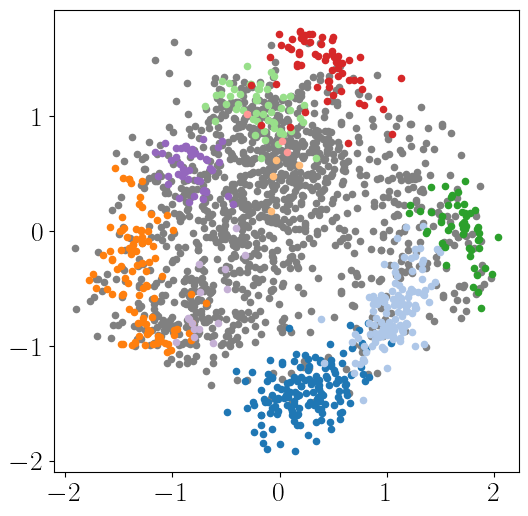

In [15]:
# PCA for visualization
pca = PCA(n_components=2)
data_2d = pca.fit_transform(data)

fig,ax = plt.subplots(figsize = (6,6))
uniqie_labs = np.unique(dbscan_labels_)
for l in uniqie_labs:
    idx = np.where(dbscan_labels_ == l)[0]
    ax.scatter(data_2d[idx,0], data_2d[idx,1], color = color_dict2[l], s = 20)

In [ ]:
# Association Rule Mining:
association_n_mine = 10000

# Pointwise Rule Mining:
pointwise_samples_per_point = 10
pointwise_prob_dim = 1/2
pointwise_prob_stop = 8/10

lambda_val = 5.0

association_rule_miner = AssociationRuleMiner(max_rules = association_n_mine, bin_type = 'mdlp')
association_rules, association_rule_labels = association_rule_miner.fit(data, dbscan_labels)

pointwise_rule_miner = PointwiseMinerV2(
    samples = pointwise_samples_per_point,
    prob_dim = pointwise_prob_dim,
    prob_stop = pointwise_prob_stop,
)
pointwise_rules, pointwise_rule_labels = pointwise_rule_miner.fit(data, dbscan_labels)

In [16]:
np.random.seed(seed)

In [20]:
n_core = 10
epsilon = 1.5
n_rules = 10

# Association Rule Mining
association_n_mine = 10000

# Pointwise Rule Mining:
pointwise_samples_per_point = 10
pointwise_prob_dim = 1/2
pointwise_prob_stop = 8/10

lambda_val = 5.0


# DBSCAN
dbscan = DBSCAN(eps=epsilon, min_samples=n_core)
dbscan.fit(data)
dbscan_labels_ = dbscan.labels_
dbscan_labels = labels_format(dbscan_labels_)
dbscan_n_clusters = len(unique_labels(dbscan_labels, ignore = {-1}))
dbscan_assignment = labels_to_assignment(dbscan_labels, n_labels = dbscan_n_clusters, ignore = {-1})


# Decision Tree
dtree = DecisionTree(
    max_leaf_nodes = n_rules
)
dtree.fit(data, dbscan_labels)
dtree_labels = dtree.predict(data)
dtree_labels_ = flatten_labels(dtree_labels)
dtree_leaf_labels = dtree.get_leaf_labels()
# This should ignore any rules which are assigned to the outlier class 
dtree_rule_assignment = labels_to_assignment(dtree_leaf_labels, n_labels = dbscan_n_clusters, ignore = {-1})
dtree_data_to_rule_assignment = dtree.get_data_to_rules_assignment(data)
dtree_data_to_cluster_assignment = dtree_data_to_rule_assignment @ dtree_rule_assignment


# Removal Tree
rem_tree = RemovalTree(num_clusters = len(np.unique(dbscan_labels_)))
rem_tree.fit(data, dbscan_labels)
rem_tree_labels = rem_tree.predict(data, remove_outliers = False)
rem_tree_labels_ = flatten_labels(rem_tree_labels)
rem_tree_leaf_labels = rem_tree.get_leaf_labels()
# This should ignore any rules which are assigned to the outlier class 
rem_tree_rule_assignment = labels_to_assignment(rem_tree_leaf_labels, n_labels = dbscan_n_clusters, ignore = {-1})
rem_tree_data_to_rule_assignment = rem_tree.get_data_to_rules_assignment(data)
rem_tree_data_to_cluster_assignment = rem_tree_data_to_rule_assignment @ rem_tree_rule_assignment


# Decision Set Clustering — Association Rules
association_rule_miner = AssociationRuleMiner(max_rules = association_n_mine, bin_type = 'mdlp')
dsclust1 = DSCluster(lambd = lambda_val, n_rules = n_rules, rule_miner = association_rule_miner)
dsclust1.fit(data, dbscan_labels)
dsclust1_labels = dsclust1.predict(data)
dsclust1_labels_ = flatten_labels(dsclust1_labels)
# This should ignore any rules which are assigned to the outlier class, but note that we already preventing outlier rules 
# in the DSCluster algorithm. This is here mostly for consistency.
dsclust1_rule_assignment = labels_to_assignment(dsclust1.decision_set_labels, n_labels = dbscan_n_clusters, ignore = {-1})
dsclust1_data_to_rule_assignment = dsclust1.get_data_to_rules_assignment(data)
dsclust1_data_to_cluster_assignment = dsclust1_data_to_rule_assignment @ dsclust1_rule_assignment 


# Decision Set Clustering — Pointwise
pointwise_rule_miner = PointwiseMinerV2(
    samples = pointwise_samples_per_point,
    prob_dim = pointwise_prob_dim,
    prob_stop = pointwise_prob_stop,
)
dsclust2 = DSCluster(lambd = lambda_val, n_rules = n_rules, rule_miner = pointwise_rule_miner)
dsclust2.fit(data, dbscan_labels)
dsclust2_labels = dsclust2.predict(data)
dsclust2_labels_ = flatten_labels(dsclust2_labels)
# This should ignore any rules which are assigned to the outlier class, but note that we already preventing outlier rules 
# in the DSCluster algorithm. This is here mostly for consistency.
dsclust2_rule_assignment = labels_to_assignment(dsclust2.decision_set_labels, n_labels = dbscan_n_clusters, ignore = {-1})
dsclust2_data_to_rule_assignment = dsclust2.get_data_to_rules_assignment(data)
dsclust2_data_to_cluster_assignment = dsclust2_data_to_rule_assignment @ dsclust2_rule_assignment 

In [ ]:
lambdas = [
    1/n_mine,
    1/(2 * data.shape[1] * n_mine),
    1/(len(data) * (n_mine**2)),
    1/(len(data) * (n_mine**2)),
    0,
    1/(data.shape[0] * n_mine),
    1/(data.shape[0])
]

ids_set = IdsSet(
    lambdas = lambdas,
    rule_miner = association_rule_miner,
    rules = association_rules,
    rule_labels = association_rule_labels
)
ids_set.fit(data, dbscan_labels)
ids_set_labels = ids_set.predict(data)
#ids_set_labels_ = flatten_labels(ids_set_labels)
ids_set_labels_ = np.array([min(labs) for labs in ids_set_labels])
ids_set_rule_assignment = labels_to_assignment(ids_set.decision_set_labels, n_labels = dbscan_n_clusters, ignore = {-1})
ids_set_data_to_rule_assignment = ids_set.get_data_to_rules_assignment(data)
ids_set_data_to_cluster_assignment = ids_set_data_to_rule_assignment @ ids_set_rule_assignment

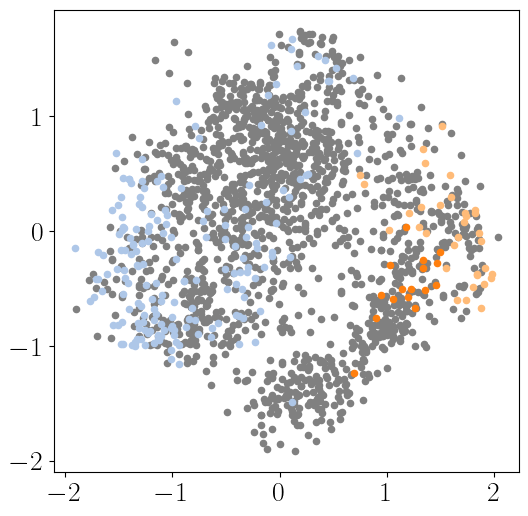

In [24]:
fig,ax = plt.subplots(figsize = (6,6))
uni_labs = np.unique(dsclust2_labels_)
for l in uni_labs:
    idx = np.where(dsclust2_labels_ == l)[0]
    ax.scatter(data_2d[idx,0], data_2d[idx,1], color = color_dict2[l], s = 20)

In [32]:
dtree_base_coverage = coverage(dtree_data_to_cluster_assignment, percentage = False)

In [33]:
dtree_base_coverage

1797

In [35]:
n

1797

In [48]:
# Robustness Experiment: Fraction of data points which change cluster assignment 
# after trials with random noise
samples = 10000

dtree_counts = np.zeros(samples)
remtree_counts = np.zeros(samples)
dsclust1_counts = np.zeros(samples)
dsclust2_counts = np.zeros(samples)

for i in range(samples):
    # Generate random noise
    noise = np.random.normal(0, 0.1, size = data.shape)
    noisy_data = data + noise

    # Decision Tree
    dtree_noisy_labels = dtree.predict(noisy_data)
    dtree_counts[i] = label_differences(
        true_labels = dtree_labels,
        pred_labels = dtree_noisy_labels,
        percentage = True,
        ignore = {-1}
    )

    # Removal Tree
    rem_tree_noisy_labels = rem_tree.predict(noisy_data, remove_outliers = False)
    remtree_counts[i] = label_differences(
        true_labels = rem_tree_labels,
        pred_labels = rem_tree_noisy_labels,
        percentage = True,
        ignore = {-1}
    )

    # DSCluster - Association Rules
    dsclust1_noisy_labels = dsclust1.predict(noisy_data)
    dsclust1_counts[i] = label_differences(
        true_labels = dsclust1_labels,
        pred_labels = dsclust1_noisy_labels,
        percentage = True,
        ignore = {-1}
    )

    # DSCluster - Pointwise
    dsclust2_noisy_labels = dsclust2.predict(noisy_data)
    dsclust2_counts[i] = label_differences(
        true_labels = dsclust2_labels,
        pred_labels = dsclust2_noisy_labels,
        percentage = True,
        ignore = {-1}
    )

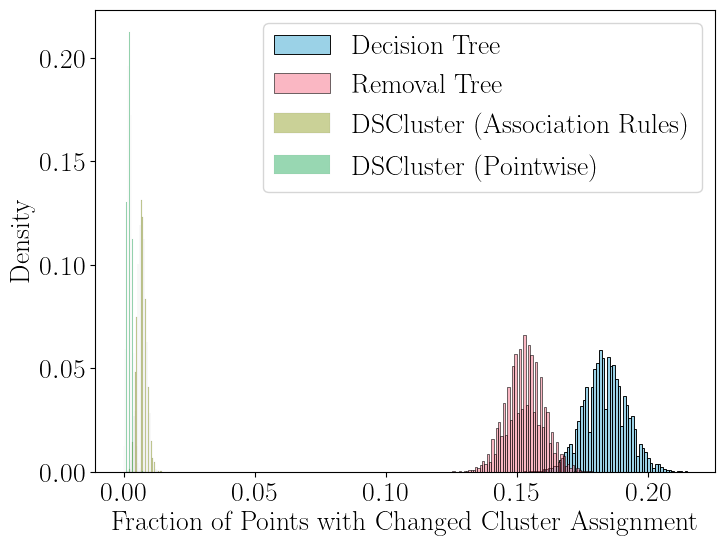

In [54]:
# Plot histogram of robustness results
fig,ax = plt.subplots(figsize = (8,6))
sns.histplot(dtree_counts, alpha = 0.5, stat = 'probability', label = 'Decision Tree', color = cmap(5), ax = ax)
sns.histplot(remtree_counts, alpha = 0.5, stat = 'probability', label = 'Removal Tree', color = cmap(0), ax = ax)
sns.histplot(dsclust1_counts, alpha = 0.5, stat = 'probability', label = 'DSCluster (Association Rules)', color = cmap(2), ax = ax)
sns.histplot(dsclust2_counts, alpha = 0.5, stat = 'probability', label = 'DSCluster (Pointwise)', color = cmap(3), ax = ax)
ax.set_xlabel('Fraction of Points with Changed Cluster Assignment')
ax.set_ylabel('Density')
ax.legend()

In [ ]:
# Robustness Experiment: Counting difference in coverage and mistakes after trials with random noise
samples = 1000

dtree_base_count = uncovered_mistake_score(
    ground_truth_assignment = dbscan_assignment,
    data_to_rule_assignment = dtree_data_to_rule_assignment,
    rule_to_cluster_assignment = dtree_rule_assignment
)
dtree_counts = np.zeros(samples)

rem_tree_base_count = uncovered_mistake_score(
    ground_truth_assignment = dbscan_assignment,
    data_to_rule_assignment = rem_tree_data_to_rule_assignment,
    rule_to_cluster_assignment = rem_tree_rule_assignment
)
remtree_counts = np.zeros(samples)

dsclust1_base_count = uncovered_mistake_score(
    ground_truth_assignment = dbscan_assignment,
    data_to_rule_assignment = dsclust1_data_to_rule_assignment,
    rule_to_cluster_assignment = dsclust1_rule_assignment
)
dsclust1_counts = np.zeros(samples)

dsclust2_base_count = uncovered_mistake_score(
    ground_truth_assignment = dbscan_assignment,
    data_to_rule_assignment = dsclust2_data_to_rule_assignment,
    rule_to_cluster_assignment = dsclust2_rule_assignment
)
dsclust2_counts = np.zeros(samples)

for i in range(samples):
    # Generate random noise
    noise = np.random.normal(0, 0.1, size = data.shape)
    noisy_data = data + noise

    # Decision Tree
    dtree_noisy_data_to_rule_assignment = dtree.get_data_to_rules_assignment(noisy_data)
    dtree_noisy_count = uncovered_mistake_score(
        ground_truth_assignment = dbscan_assignment,
        data_to_rule_assignment = dtree_noisy_data_to_rule_assignment,
        rule_to_cluster_assignment = dtree_rule_assignment
    )
    dtree_counts[i] = (dtree_noisy_count - dtree_base_count) / dtree_base_count

    # Removal Tree
    rem_tree_noisy_data_to_rule_assignment = rem_tree.get_data_to_rules_assignment(noisy_data)
    rem_tree_noisy_count = uncovered_mistake_score(
        ground_truth_assignment = dbscan_assignment,
        data_to_rule_assignment = rem_tree_noisy_data_to_rule_assignment,
        rule_to_cluster_assignment = rem_tree_rule_assignment
    )
    remtree_counts[i] = (rem_tree_noisy_count - rem_tree_base_count) / rem_tree_base_count

    # DSCluster - Association Rules
    dsclust1_noisy_data_to_rule_assignment = dsclust1.get_data_to_rules_assignment(noisy_data)
    dsclust1_noisy_count = uncovered_mistake_score(
        ground_truth_assignment = dbscan_assignment,
        data_to_rule_assignment = dsclust1_noisy_data_to_rule_assignment,
        rule_to_cluster_assignment = dsclust1_rule_assignment
    )
    dsclust1_counts[i] = (dsclust1_noisy_count - dsclust1_base_count) / dsclust1_base_count

    # DSCluster - Pointwise
    dsclust2_noisy_data_to_rule_assignment = dsclust2.get_data_to_rules_assignment(noisy_data)
    dsclust2_noisy_count = uncovered_mistake_score(
        ground_truth_assignment = dbscan_assignment,
        data_to_rule_assignment = dsclust2_noisy_data_to_rule_assignment,
        rule_to_cluster_assignment = dsclust2_rule_assignment
    )
    dsclust2_counts[i] = (dsclust2_noisy_count - dsclust2_base_count) / dsclust2_base_count


In [67]:
# Robustness Experiment: Counting difference in coverage and mistakes after trials with random noise
samples = 1000
lambda_val = 5.0

dtree_base_score = coverage_mistake_score(
    lambda_val = lambda_val,
    ground_truth_assignment = dbscan_assignment,
    data_to_rule_assignment = dtree_data_to_rule_assignment,
    rule_to_cluster_assignment = dtree_rule_assignment
)
dtree_counts = np.zeros(samples)

rem_tree_base_score = coverage_mistake_score(
    lambda_val = lambda_val,
    ground_truth_assignment = dbscan_assignment,
    data_to_rule_assignment = rem_tree_data_to_rule_assignment,
    rule_to_cluster_assignment = rem_tree_rule_assignment
)
remtree_counts = np.zeros(samples)

dsclust1_base_score = coverage_mistake_score(
    lambda_val = lambda_val,
    ground_truth_assignment = dbscan_assignment,
    data_to_rule_assignment = dsclust1_data_to_rule_assignment,
    rule_to_cluster_assignment = dsclust1_rule_assignment
)
dsclust1_counts = np.zeros(samples)

dsclust2_base_score = coverage_mistake_score(
    lambda_val = lambda_val,
    ground_truth_assignment = dbscan_assignment,
    data_to_rule_assignment = dsclust2_data_to_rule_assignment,
    rule_to_cluster_assignment = dsclust2_rule_assignment
)
dsclust2_counts = np.zeros(samples)

for i in range(samples):
    # Generate random noise
    noise = np.random.normal(0, 0.1, size = data.shape)
    noisy_data = data + noise

    # Decision Tree
    dtree_noisy_data_to_rule_assignment = dtree.get_data_to_rules_assignment(noisy_data)
    dtree_noisy_score = coverage_mistake_score(
        lambda_val = lambda_val,
        ground_truth_assignment = dbscan_assignment,
        data_to_rule_assignment = dtree_noisy_data_to_rule_assignment,
        rule_to_cluster_assignment = dtree_rule_assignment
    )
    dtree_counts[i] = (dtree_noisy_score - dtree_base_score) / dtree_base_score

    # Removal Tree
    rem_tree_noisy_data_to_rule_assignment = rem_tree.get_data_to_rules_assignment(noisy_data)
    rem_tree_noisy_score = coverage_mistake_score(
        lambda_val = lambda_val,
        ground_truth_assignment = dbscan_assignment,
        data_to_rule_assignment = rem_tree_noisy_data_to_rule_assignment,
        rule_to_cluster_assignment = rem_tree_rule_assignment
    )
    remtree_counts[i] = (rem_tree_noisy_score - rem_tree_base_score) / rem_tree_base_score

    # DSCluster - Association Rules
    dsclust1_noisy_data_to_rule_assignment = dsclust1.get_data_to_rules_assignment(noisy_data)
    dsclust1_noisy_score = coverage_mistake_score(
        lambda_val = lambda_val,
        ground_truth_assignment = dbscan_assignment,
        data_to_rule_assignment = dsclust1_noisy_data_to_rule_assignment,
        rule_to_cluster_assignment = dsclust1_rule_assignment
    )
    dsclust1_counts[i] = (dsclust1_noisy_score - dsclust1_base_score) / dsclust1_base_score

    # DSCluster - Pointwise
    dsclust2_noisy_data_to_rule_assignment = dsclust2.get_data_to_rules_assignment(noisy_data)
    dsclust2_noisy_score = coverage_mistake_score(
        lambda_val = lambda_val,
        ground_truth_assignment = dbscan_assignment,
        data_to_rule_assignment = dsclust2_noisy_data_to_rule_assignment,
        rule_to_cluster_assignment = dsclust2_rule_assignment
    )
    dsclust2_counts[i] = (dsclust2_noisy_score - dsclust2_base_score) / dsclust2_base_score

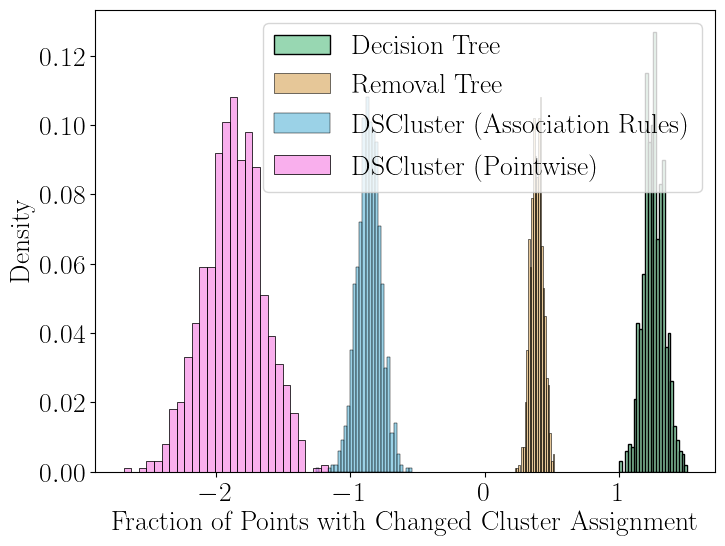

In [68]:
# Plot histogram of robustness results
fig,ax = plt.subplots(figsize = (8,6))
sns.histplot(dtree_counts, alpha = 0.5, stat = 'probability', label = 'Decision Tree', color = cmap(3), ax = ax)
sns.histplot(remtree_counts, alpha = 0.5, stat = 'probability', label = 'Removal Tree', color = cmap(1), ax = ax)
sns.histplot(dsclust1_counts, alpha = 0.5, stat = 'probability', label = 'DSCluster (Association Rules)', color = cmap(5), ax = ax)
sns.histplot(dsclust2_counts, alpha = 0.5, stat = 'probability', label = 'DSCluster (Pointwise)', color = cmap(7), ax = ax)
ax.set_xlabel('Fraction of Points with Changed Cluster Assignment')
ax.set_ylabel('Density')
ax.legend()

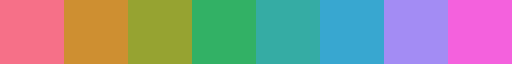

In [59]:
cmap

In [38]:
dsclust2_counts

array([0.17807457, 0.17584864, 0.16805787, 0.17529215, 0.16193656,
       0.17473567, 0.1869783 , 0.17473567, 0.17584864, 0.1769616 ,
       0.19532554, 0.1769616 , 0.17250974, 0.16917084, 0.18085698,
       0.16583194, 0.17863105, 0.16694491, 0.16917084, 0.15692821,
       0.18753478, 0.17195326, 0.17751809, 0.16861436, 0.1736227 ,
       0.16972732, 0.17250974, 0.1803005 , 0.16471898, 0.15581525,
       0.17863105, 0.17028381, 0.17584864, 0.18753478, 0.1769616 ,
       0.17918753, 0.1803005 , 0.16360601, 0.16638843, 0.17751809,
       0.17974402, 0.18141347, 0.17139677, 0.18141347, 0.17028381,
       0.18475237, 0.17139677, 0.16082359, 0.17139677, 0.16861436,
       0.16416249, 0.17751809, 0.16583194, 0.17195326, 0.17250974,
       0.17473567, 0.16805787, 0.17195326, 0.17918753, 0.1736227 ,
       0.1736227 , 0.17918753, 0.18141347, 0.17751809, 0.18252643,
       0.16861436, 0.16972732, 0.19254313, 0.17195326, 0.17640512,
       0.17863105, 0.17306622, 0.17918753, 0.16972732, 0.16138

## Moons

In [ ]:
data,labels = noisy_moons
k = 2
true_assignment = labels_to_assignment(labels_format(labels), k)

n_core = 5
density_distances = density_distance(data, n_core = n_core)
epsilon = min_inter_cluster_distance(density_distances, true_assignment) - 0.01
n_rules = 5


# DBSCAN
dbscan = DBSCAN(eps=epsilon, min_samples=n_core)
dbscan.fit(data)
# NOTE: this is dbscan*, where all non-core points are outliers
dbscan_labels_ = [label if i in dbscan.core_sample_indices_ else -1 for i,label in enumerate(dbscan.labels_)]
dbscan_labels = labels_format(dbscan_labels_)
dbscan_n_clusters = len(unique_labels(dbscan_labels, ignore = {-1}))
dbscan_assignment = labels_to_assignment(dbscan_labels, n_labels = dbscan_n_clusters, ignore = {-1})


# Decision Tree
dtree = DecisionTree(
    max_leaf_nodes = n_rules
)
dtree.fit(data, dbscan_labels)
dtree_labels = dtree.predict(data)
dtree_labels_ = flatten_labels(dtree_labels)
dtree_leaf_labels = dtree.get_leaf_labels()
# This should ignore any rules which are assigned to the outlier class 
dtree_rule_assignment = labels_to_assignment(dtree_leaf_labels, n_labels = dbscan_n_clusters, ignore = {-1})
dtree_data_to_rule_assignment = dtree.get_data_to_rules_assignment(data)
dtree_data_to_cluster_assignment = dtree_data_to_rule_assignment @ dtree_rule_assignment


# Removal Tree
rem_tree = RemovalTree(num_clusters = len(np.unique(dbscan_labels_)))
rem_tree.fit(data, dbscan_labels)
rem_tree_labels = rem_tree.predict(data, remove_outliers = False)
rem_tree_labels_ = flatten_labels(rem_tree_labels)
rem_tree_leaf_labels = rem_tree.get_leaf_labels()
# This should ignore any rules which are assigned to the outlier class 
rem_tree_rule_assignment = labels_to_assignment(rem_tree_leaf_labels, n_labels = dbscan_n_clusters, ignore = {-1})
rem_tree_data_to_rule_assignment = rem_tree.get_data_to_rules_assignment(data)
rem_tree_data_to_cluster_assignment = rem_tree_data_to_rule_assignment @ rem_tree_rule_assignment


# Decision Set Clustering
dsclust = DSCluster(lambd = 10, n_rules = n_rules, n_features = 2, rules_per_point = 1)
dsclust.fit(data, dbscan_labels)
dsclust_labels = dsclust.predict(data)
dsclust_labels_ = flatten_labels(dsclust_labels)
# This should ignore any rules which are assigned to the outlier class, but note that we already preventing outlier rules 
# in the DSCluster algorithm. This is here mostly for consistency.
dsclust_rule_assignment = labels_to_assignment(dsclust.decision_set_labels, n_labels = dbscan_n_clusters, ignore = {-1})
dsclust_data_to_rule_assignment = dsclust.get_data_to_rules_assignment(data)
dsclust_data_to_cluster_assignment = dsclust_data_to_rule_assignment @ dsclust_rule_assignment 

In [ ]:
fig,axs = plt.subplots(nrows = 1, ncols = 4, figsize = (20,4), dpi = 100)

# DBSCAN
if -1 in dbscan_labels_:
    axs[0].scatter(data[:,0], data[:,1], c = dbscan_labels_, cmap = cmap_subset_outliers2, s = 20)
else:
    axs[0].scatter(data[:,0], data[:,1], c = dbscan_labels_, cmap = cmap_subset2, s = 20)
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')
axs[0].set_title("DBSCAN")


# Decision Tree
if -1 in dtree_labels_:
    axs[1].scatter(data[:,0], data[:,1], c = dtree_labels_, cmap = cmap_subset_outliers2, s = 20)
else:
    axs[1].scatter(data[:,0], data[:,1], c = dtree_labels_, cmap = cmap_subset2, s = 20)
plot_decision_boundaries(dtree, data, ax = axs[1], resolution = 1000, label_array = False)
axs[1].set_xlabel('x')
axs[1].set_title("Decision Tree")


# Removal Tree
if -1 in rem_tree_labels_:
    axs[2].scatter(data[:,0], data[:,1], c = rem_tree_labels_, cmap = cmap_subset_outliers2, s = 20)
else:
    axs[2].scatter(data[:,0], data[:,1], c = rem_tree_labels_, cmap = cmap_subset2, s = 20)
plot_decision_boundaries(rem_tree, data, ax = axs[2], resolution = 1000, label_array = False)
axs[2].set_xlabel('x')
axs[2].set_title("Removal Tree")


# Decision Set Clustering
if -1 in dsclust_labels_:
    axs[3].scatter(data[:,0], data[:,1], c = dsclust_labels_, cmap = cmap_subset_outliers2, s = 20)
else:
    axs[3].scatter(data[:,0], data[:,1], c = dsclust_labels_, cmap = cmap_subset2, s = 20)
plot_rule_boxes(dsclust, data, axs[3])
axs[3].set_xlabel('x')
axs[3].set_title("DSCluster")

axs[1].yaxis.set_visible(False)
axs[2].yaxis.set_visible(False)
axs[3].yaxis.set_visible(False)

In [ ]:
########################################################################################
# Setup
seed = 342
np.random.seed(seed)

data, labels = noisy_moons

n_core = 5
density_distances = density_distance(data, n_core = n_core)
epsilon = min_inter_cluster_distance(density_distances, true_assignment) - 0.01

lambda_val = 10

min_rules = 2
max_rules = 20

########################################################################################
# Baseline DBSCAN
dbscan_base = DBSCANBase(eps=epsilon, n_core=n_core)
dbscan_assignment = dbscan_base.assign(data)

# Decision Tree
decision_tree_params = {}
decision_tree_mod = DecisionTreeMod(
    model = DecisionTree,
    fitting_params = decision_tree_params,
    min_rules = min_rules,
    name = 'Decision-Tree'
)

# Removal Tree
rem_tree_params = {'num_clusters' : len(unique_labels(dbscan_base.labels))}
rem_tree_mod = DecisionTreeMod(
    model = RemovalTree,
    fitting_params = rem_tree_params,
    min_rules = min_rules,
    name = 'Removal-Tree'
)

# Decision Set Clustering
dsclust_params = {'lambd' : lambda_val, 'n_features' : 2, 'rules_per_point' : 3}
dsclust_mod = DecisionSetMod(
    model = DSCluster,
    fitting_params = dsclust_params,
    min_rules = min_rules,
    name = 'Decision-Set-Clustering'
)

#######################################################################################

coverage_mistake_measure = CoverageMistakeScore(
    lambda_val = lambda_val,
    ground_truth_assignment = dbscan_assignment
)

silhouette_measure = Silhouette(
    distances = density_distances
)

########################################################################################

exp = MaxRulesExperiment(
    data = data,
    baseline_list = [dbscan_base],
    module_list = [decision_tree_mod, rem_tree_mod, dsclust_mod],
    measurement_fns = [coverage_mistake_measure, silhouette_measure],
    n_samples = 10,
    cpu_count = 1
)

exp_df = exp.run(n_steps = max_rules - min_rules)


In [ ]:
plot_df = exp_df.T.groupby(level=[0,1,2]).mean().T
plot_std_df = exp_df.T.groupby(level=[0,1,2]).std().T
rule_domain = np.arange(2,20)

fig,axs = plt.subplots(nrows = 1, ncols = 3, figsize = (20,4), dpi = 100)

subplot_df = plot_df.loc[:,'Coverage-Mistake-Score']
subplot_std_df = plot_std_df.loc[:,'Coverage-Mistake-Score']
axs[0].plot(rule_domain, subplot_df.loc[:,'DBSCAN'], linewidth = 3, label = 'DBSCAN', color = 'k', alpha = 0.25)
axs[0].plot(rule_domain, subplot_df.loc[:,'Decision-Tree'], linewidth = 3, label = 'Decision Tree', color = cmap(5))
axs[0].plot(rule_domain, subplot_df.loc[:,'Removal-Tree'], linewidth = 3, label = 'Removal Tree', linestyle = '--', color = 'k', alpha = 0.25)
axs[0].plot(rule_domain, subplot_df.loc[:,'Decision-Set-Clustering'], linewidth = 3, label = 'DSCluster', color = cmap(3))
axs[0].fill_between(
    rule_domain, 
    (subplot_df.loc[:,'Decision-Set-Clustering'] - subplot_std_df.loc[:,'Decision-Set-Clustering']).iloc[:,0],
    (subplot_df.loc[:,'Decision-Set-Clustering'] + subplot_std_df.loc[:,'Decision-Set-Clustering']).iloc[:,0],
    color= cmap(3),
    alpha=0.3
)
axs[0].set_xlabel('Max Rules')
axs[0].set_ylabel('Objective')



subplot_df = plot_df.loc[:,'Silhouette']
subplot_std_df = plot_std_df.loc[:,'Silhouette']
axs[1].plot(rule_domain, subplot_df.loc[:,'DBSCAN'], linewidth = 3, label = 'DBSCAN', color = 'k', alpha = 0.25)
axs[1].plot(rule_domain, subplot_df.loc[:,'Decision-Tree'], linewidth = 3, label = 'Decision Tree', color = cmap(5))
axs[1].plot(rule_domain, subplot_df.loc[:,'Removal-Tree'], linewidth = 3, label = 'Removal Tree', linestyle = '--', color = 'k', alpha = 0.25)
axs[1].plot(rule_domain, subplot_df.loc[:,'Decision-Set-Clustering'], linewidth = 3, label = 'DSCluster', color = cmap(3))
axs[1].fill_between(
    rule_domain, 
    (subplot_df.loc[:,'Decision-Set-Clustering'] - subplot_std_df.loc[:,'Decision-Set-Clustering']).iloc[:,0],
    (subplot_df.loc[:,'Decision-Set-Clustering'] + subplot_std_df.loc[:,'Decision-Set-Clustering']).iloc[:,0],
    color= cmap(3),
    alpha=0.3
)
axs[1].set_xlabel('Max Rules')
axs[1].set_ylabel('Silhouette Score')

subplot_df = plot_df.loc[:,'weighted-average-rule-length']
subplot_std_df = plot_std_df.loc[:,'weighted-average-rule-length']
axs[2].plot(rule_domain, subplot_df.loc[:,'DBSCAN'], linewidth = 3, label = 'DBSCAN', color = 'k', alpha = 0.25)
axs[2].plot(rule_domain, subplot_df.loc[:,'Decision-Tree'], linewidth = 3, label = 'Decision Tree', color = cmap(5))
axs[2].plot(rule_domain, subplot_df.loc[:,'Removal-Tree'], linewidth = 3, label = 'Removal Tree', linestyle = '--', color = 'k', alpha = 0.25)
axs[2].plot(rule_domain, subplot_df.loc[:,'Decision-Set-Clustering'], linewidth = 3, label = 'DSCluster', color = cmap(3))
axs[2].fill_between(
    rule_domain, 
    (subplot_df.loc[:,'Decision-Set-Clustering'] - subplot_std_df.loc[:,'Decision-Set-Clustering']).iloc[:,0],
    (subplot_df.loc[:,'Decision-Set-Clustering'] + subplot_std_df.loc[:,'Decision-Set-Clustering']).iloc[:,0],
    color= cmap(3),
    alpha=0.3
)
axs[2].set_xlabel('Max Rules')
axs[2].set_ylabel('Weighted Average Rule Length')

plt.legend(ncols = 4, bbox_to_anchor=(0.25, -0.25))



## Spiral

In [ ]:
spiral_df = pd.read_csv('../data/synthetic/spiral.csv', index_col = 0)

In [ ]:
data = spiral_df.iloc[:,[0,1]].to_numpy()
labels = spiral_df.loc[:,'labels'].to_numpy() - 1

k = 3
true_assignment = labels_to_assignment(labels_format(labels), k)

n_core = 5
density_distances = density_distance(data, n_core = n_core)
epsilon = min_inter_cluster_distance(density_distances, true_assignment) - 0.01
n_rules = 15

# DBSCAN
dbscan = DBSCAN(eps=epsilon, min_samples=n_core)
dbscan.fit(data)
# NOTE: this is dbscan*, where all non-core points are outliers
dbscan_labels_ = [label if i in dbscan.core_sample_indices_ else -1 for i,label in enumerate(dbscan.labels_)]
dbscan_labels = labels_format(dbscan_labels_)
dbscan_n_clusters = len(unique_labels(dbscan_labels, ignore = {-1}))
dbscan_assignment = labels_to_assignment(dbscan_labels, n_labels = dbscan_n_clusters, ignore = {-1})


# Decision Tree
dtree = DecisionTree(
    max_leaf_nodes = n_rules
)
dtree.fit(data, dbscan_labels)
dtree_labels = dtree.predict(data)
dtree_labels_ = flatten_labels(dtree_labels)
dtree_leaf_labels = dtree.get_leaf_labels()
# This should ignore any rules which are assigned to the outlier class 
dtree_rule_assignment = labels_to_assignment(dtree_leaf_labels, n_labels = dbscan_n_clusters, ignore = {-1})
dtree_data_to_rule_assignment = dtree.get_data_to_rules_assignment(data)
dtree_data_to_cluster_assignment = dtree_data_to_rule_assignment @ dtree_rule_assignment


# Removal Tree
rem_tree = RemovalTree(num_clusters = len(np.unique(dbscan_labels_)))
rem_tree.fit(data, dbscan_labels)
rem_tree_labels = rem_tree.predict(data, remove_outliers = False)
rem_tree_labels_ = flatten_labels(rem_tree_labels)
rem_tree_leaf_labels = rem_tree.get_leaf_labels()
# This should ignore any rules which are assigned to the outlier class 
rem_tree_rule_assignment = labels_to_assignment(rem_tree_leaf_labels, n_labels = dbscan_n_clusters, ignore = {-1})
rem_tree_data_to_rule_assignment = rem_tree.get_data_to_rules_assignment(data)
rem_tree_data_to_cluster_assignment = rem_tree_data_to_rule_assignment @ rem_tree_rule_assignment


# Decision Set Clustering
dsclust = DSCluster(lambd = 10, n_rules = n_rules, n_features = 2, rules_per_point = 1)
dsclust.fit(data, dbscan_labels)
dsclust_labels = dsclust.predict(data)
dsclust_labels_ = flatten_labels(dsclust_labels)
# This should ignore any rules which are assigned to the outlier class, but note that we already preventing outlier rules 
# in the DSCluster algorithm. This is here mostly for consistency.
dsclust_rule_assignment = labels_to_assignment(dsclust.decision_set_labels, n_labels = dbscan_n_clusters, ignore = {-1})
dsclust_data_to_rule_assignment = dsclust.get_data_to_rules_assignment(data)
dsclust_data_to_cluster_assignment = dsclust_data_to_rule_assignment @ dsclust_rule_assignment 

In [ ]:
fig,axs = plt.subplots(nrows = 1, ncols = 4, figsize = (20,4), dpi = 100)

# DBSCAN
if -1 in dbscan_labels_:
    axs[0].scatter(data[:,0], data[:,1], c = dbscan_labels_, cmap = cmap_subset_outliers2, s = 20)
else:
    axs[0].scatter(data[:,0], data[:,1], c = dbscan_labels_, cmap = cmap_subset2, s = 20)
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')
axs[0].set_title("DBSCAN")


# Decision Tree
if -1 in dtree_labels_:
    axs[1].scatter(data[:,0], data[:,1], c = dtree_labels_, cmap = cmap_subset_outliers2, s = 20)
else:
    axs[1].scatter(data[:,0], data[:,1], c = dtree_labels_, cmap = cmap_subset2, s = 20)
plot_decision_boundaries(dtree, data, ax = axs[1], resolution = 1000, label_array = False)
axs[1].set_xlabel('x')
axs[1].set_title("Decision Tree")


# Removal Tree
if -1 in rem_tree_labels_:
    axs[2].scatter(data[:,0], data[:,1], c = rem_tree_labels_, cmap = cmap_subset_outliers2, s = 20)
else:
    axs[2].scatter(data[:,0], data[:,1], c = rem_tree_labels_, cmap = cmap_subset2, s = 20)
plot_decision_boundaries(rem_tree, data, ax = axs[2], resolution = 1000, label_array = False)
axs[2].set_xlabel('x')
axs[2].set_title("Removal Tree")


# Decision Set Clustering
if -1 in dsclust_labels_:
    axs[3].scatter(data[:,0], data[:,1], c = dsclust_labels_, cmap = cmap_subset_outliers2, s = 20)
else:
    axs[3].scatter(data[:,0], data[:,1], c = dsclust_labels_, cmap = cmap_subset2, s = 20)
plot_rule_boxes(dsclust, data, axs[3])
axs[3].set_xlabel('x')
axs[3].set_title("DSCluster")

axs[1].yaxis.set_visible(False)
axs[2].yaxis.set_visible(False)
axs[3].yaxis.set_visible(False)

In [ ]:
########################################################################################
# Setup
seed = 342
np.random.seed(seed)

data = spiral_df.iloc[:,[0,1]].to_numpy()
labels = spiral_df.loc[:,'labels'].to_numpy() - 1

n_core = 5
density_distances = density_distance(data, n_core = n_core)
epsilon = min_inter_cluster_distance(density_distances, true_assignment) - 0.01

lambda_val = 10

min_rules = 2
max_rules = 20

########################################################################################
# Baseline DBSCAN
dbscan_base = DBSCANBase(eps=epsilon, n_core=n_core)
dbscan_assignment = dbscan_base.assign(data)

# Decision Tree
decision_tree_params = {}
decision_tree_mod = DecisionTreeMod(
    model = DecisionTree,
    fitting_params = decision_tree_params,
    min_rules = min_rules,
    name = 'Decision-Tree'
)

# Removal Tree
rem_tree_params = {'num_clusters' : len(unique_labels(dbscan_base.labels))}
rem_tree_mod = DecisionTreeMod(
    model = RemovalTree,
    fitting_params = rem_tree_params,
    min_rules = min_rules,
    name = 'Removal-Tree'
)

# Decision Set Clustering
dsclust_params = {'lambd' : lambda_val, 'n_features' : 2, 'rules_per_point' : 3}
dsclust_mod = DecisionSetMod(
    model = DSCluster,
    fitting_params = dsclust_params,
    min_rules = min_rules,
    name = 'Decision-Set-Clustering'
)

#######################################################################################

coverage_mistake_measure = CoverageMistakeScore(
    lambda_val = lambda_val,
    ground_truth_assignment = dbscan_assignment
)

silhouette_measure = Silhouette(
    distances = density_distances
)

########################################################################################

exp = MaxRulesExperiment(
    data = data,
    baseline_list = [dbscan_base],
    module_list = [decision_tree_mod, rem_tree_mod, dsclust_mod],
    measurement_fns = [coverage_mistake_measure, silhouette_measure],
    n_samples = 10,
    cpu_count = 1
)

exp_df = exp.run(n_steps = max_rules - min_rules)


In [ ]:
plot_df = exp_df.T.groupby(level=[0,1,2]).mean().T
plot_std_df = exp_df.T.groupby(level=[0,1,2]).std().T
rule_domain = np.arange(2,20)

fig,axs = plt.subplots(nrows = 1, ncols = 3, figsize = (20,4), dpi = 100)

subplot_df = plot_df.loc[:,'Coverage-Mistake-Score']
subplot_std_df = plot_std_df.loc[:,'Coverage-Mistake-Score']
axs[0].plot(rule_domain, subplot_df.loc[:,'DBSCAN'], linewidth = 3, label = 'DBSCAN', color = 'k', alpha = 0.25)
axs[0].plot(rule_domain, subplot_df.loc[:,'Decision-Tree'], linewidth = 3, label = 'Decision Tree', color = cmap(5))
axs[0].plot(rule_domain, subplot_df.loc[:,'Removal-Tree'], linewidth = 3, label = 'Removal Tree', linestyle = '--', color = 'k', alpha = 0.25)
axs[0].plot(rule_domain, subplot_df.loc[:,'Decision-Set-Clustering'], linewidth = 3, label = 'DSCluster', color = cmap(3))
axs[0].fill_between(
    rule_domain, 
    (subplot_df.loc[:,'Decision-Set-Clustering'] - subplot_std_df.loc[:,'Decision-Set-Clustering']).iloc[:,0],
    (subplot_df.loc[:,'Decision-Set-Clustering'] + subplot_std_df.loc[:,'Decision-Set-Clustering']).iloc[:,0],
    color= cmap(3),
    alpha=0.3
)
axs[0].set_xlabel('Max Rules')
axs[0].set_ylabel('Objective')



subplot_df = plot_df.loc[:,'Silhouette']
subplot_std_df = plot_std_df.loc[:,'Silhouette']
axs[1].plot(rule_domain, subplot_df.loc[:,'DBSCAN'], linewidth = 3, label = 'DBSCAN', color = 'k', alpha = 0.25)
axs[1].plot(rule_domain, subplot_df.loc[:,'Decision-Tree'], linewidth = 3, label = 'Decision Tree', color = cmap(5))
axs[1].plot(rule_domain, subplot_df.loc[:,'Removal-Tree'], linewidth = 3, label = 'Removal Tree', linestyle = '--', color = 'k', alpha = 0.25)
axs[1].plot(rule_domain, subplot_df.loc[:,'Decision-Set-Clustering'], linewidth = 3, label = 'DSCluster', color = cmap(3))
axs[1].fill_between(
    rule_domain, 
    (subplot_df.loc[:,'Decision-Set-Clustering'] - subplot_std_df.loc[:,'Decision-Set-Clustering']).iloc[:,0],
    (subplot_df.loc[:,'Decision-Set-Clustering'] + subplot_std_df.loc[:,'Decision-Set-Clustering']).iloc[:,0],
    color= cmap(3),
    alpha=0.3
)
axs[1].set_xlabel('Max Rules')
axs[1].set_ylabel('Silhouette Score')

subplot_df = plot_df.loc[:,'weighted-average-rule-length']
subplot_std_df = plot_std_df.loc[:,'weighted-average-rule-length']
axs[2].plot(rule_domain, subplot_df.loc[:,'DBSCAN'], linewidth = 3, label = 'DBSCAN', color = 'k', alpha = 0.25)
axs[2].plot(rule_domain, subplot_df.loc[:,'Decision-Tree'], linewidth = 3, label = 'Decision Tree', color = cmap(5))
axs[2].plot(rule_domain, subplot_df.loc[:,'Removal-Tree'], linewidth = 3, label = 'Removal Tree', linestyle = '--', color = 'k', alpha = 0.25)
axs[2].plot(rule_domain, subplot_df.loc[:,'Decision-Set-Clustering'], linewidth = 3, label = 'DSCluster', color = cmap(3))
axs[2].fill_between(
    rule_domain, 
    (subplot_df.loc[:,'Decision-Set-Clustering'] - subplot_std_df.loc[:,'Decision-Set-Clustering']).iloc[:,0],
    (subplot_df.loc[:,'Decision-Set-Clustering'] + subplot_std_df.loc[:,'Decision-Set-Clustering']).iloc[:,0],
    color= cmap(3),
    alpha=0.3
)
axs[2].set_xlabel('Max Rules')
axs[2].set_ylabel('Weighted Average Rule Length')

plt.legend(ncols = 4, bbox_to_anchor=(0.25, -0.25))

## Labyrinth

In [ ]:
labyrinth_df = pd.read_csv('../data/synthetic/labyrinth.csv', index_col = 0)

In [ ]:
data = labyrinth_df.iloc[:,[0,1]].to_numpy()
labels = labyrinth_df.loc[:,'labels'].to_numpy() - 1
k = 6
true_assignment = labels_to_assignment(labels_format(labels), k)

n_core = 20
density_distances = density_distance(data, n_core = n_core)
epsilon = min_inter_cluster_distance(density_distances, true_assignment)
n_rules = 15

# DBSCAN
dbscan = DBSCAN(eps=epsilon, min_samples=n_core)
dbscan.fit(data)
# NOTE: this is dbscan*, where all non-core points are outliers
dbscan_labels_ = [label if i in dbscan.core_sample_indices_ else -1 for i,label in enumerate(dbscan.labels_)]
dbscan_labels = labels_format(dbscan_labels_)
dbscan_n_clusters = len(unique_labels(dbscan_labels, ignore = {-1}))
dbscan_assignment = labels_to_assignment(dbscan_labels, n_labels = dbscan_n_clusters, ignore = {-1})


# Decision Tree
dtree = DecisionTree(
    max_leaf_nodes = n_rules
)
dtree.fit(data, dbscan_labels)
dtree_labels = dtree.predict(data)
dtree_labels_ = flatten_labels(dtree_labels)
dtree_leaf_labels = dtree.get_leaf_labels()
# This should ignore any rules which are assigned to the outlier class 
dtree_rule_assignment = labels_to_assignment(dtree_leaf_labels, n_labels = dbscan_n_clusters, ignore = {-1})
dtree_data_to_rule_assignment = dtree.get_data_to_rules_assignment(data)
dtree_data_to_cluster_assignment = dtree_data_to_rule_assignment @ dtree_rule_assignment


# Removal Tree
rem_tree = RemovalTree(num_clusters = len(np.unique(dbscan_labels_)))
rem_tree.fit(data, dbscan_labels)
rem_tree_labels = rem_tree.predict(data, remove_outliers = False)
rem_tree_labels_ = flatten_labels(rem_tree_labels)
rem_tree_leaf_labels = rem_tree.get_leaf_labels()
# This should ignore any rules which are assigned to the outlier class 
rem_tree_rule_assignment = labels_to_assignment(rem_tree_leaf_labels, n_labels = dbscan_n_clusters, ignore = {-1})
rem_tree_data_to_rule_assignment = rem_tree.get_data_to_rules_assignment(data)
rem_tree_data_to_cluster_assignment = rem_tree_data_to_rule_assignment @ rem_tree_rule_assignment


# Decision Set Clustering
dsclust = DSCluster(lambd = 10, n_rules = n_rules, n_features = 2, rules_per_point = 1)
dsclust.fit(data, dbscan_labels)
dsclust_labels = dsclust.predict(data)
dsclust_labels_ = flatten_labels(dsclust_labels)
# This should ignore any rules which are assigned to the outlier class, but note that we already preventing outlier rules 
# in the DSCluster algorithm. This is here mostly for consistency.
dsclust_rule_assignment = labels_to_assignment(dsclust.decision_set_labels, n_labels = dbscan_n_clusters, ignore = {-1})
dsclust_data_to_rule_assignment = dsclust.get_data_to_rules_assignment(data)
dsclust_data_to_cluster_assignment = dsclust_data_to_rule_assignment @ dsclust_rule_assignment 

In [ ]:
fig,axs = plt.subplots(nrows = 1, ncols = 4, figsize = (20,4), dpi = 100)

# DBSCAN
if -1 in dbscan_labels_:
    axs[0].scatter(data[:,0], data[:,1], c = dbscan_labels_, cmap = cmap_subset_outliers3, s = 20)
else:
    axs[0].scatter(data[:,0], data[:,1], c = dbscan_labels_, cmap = cmap_subset3, s = 20)
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')
axs[0].set_title("DBSCAN")


# Decision Tree
if -1 in dtree_labels_:
    axs[1].scatter(data[:,0], data[:,1], c = dtree_labels_, cmap = cmap_subset_outliers3, s = 20)
else:
    axs[1].scatter(data[:,0], data[:,1], c = dtree_labels_, cmap = cmap_subset3, s = 20)
plot_decision_boundaries(dtree, data, ax = axs[1], resolution = 1000, label_array = False)
axs[1].set_xlabel('x')
axs[1].set_title("Decision Tree")


# Removal Tree
if -1 in rem_tree_labels_:
    axs[2].scatter(data[:,0], data[:,1], c = rem_tree_labels_, cmap = cmap_subset_outliers3, s = 20)
else:
    axs[2].scatter(data[:,0], data[:,1], c = rem_tree_labels_, cmap = cmap_subset3, s = 20)
plot_decision_boundaries(rem_tree, data, ax = axs[2], resolution = 1000, label_array = False)
axs[2].set_xlabel('x')
axs[2].set_title("Removal Tree")


# Decision Set Clustering
if -1 in dsclust_labels_:
    axs[3].scatter(data[:,0], data[:,1], c = dsclust_labels_, cmap = cmap_subset_outliers3, s = 20)
else:
    axs[3].scatter(data[:,0], data[:,1], c = dsclust_labels_, cmap = cmap_subset3, s = 20)
plot_rule_boxes(dsclust, data, axs[3])
axs[3].set_xlabel('x')
axs[3].set_title("DSCluster")

axs[1].yaxis.set_visible(False)
axs[2].yaxis.set_visible(False)
axs[3].yaxis.set_visible(False)

In [ ]:
########################################################################################
# Setup
seed = 342
np.random.seed(seed)

data = labyrinth_df.iloc[:,[0,1]].to_numpy()
labels = labyrinth_df.loc[:,'labels'].to_numpy() - 1

n_core = 5
density_distances = density_distance(data, n_core = n_core)
epsilon = min_inter_cluster_distance(density_distances, true_assignment) - 0.01

lambda_val = 10

min_rules = 2
max_rules = 20

########################################################################################
# Baseline DBSCAN
dbscan_base = DBSCANBase(eps=epsilon, n_core=n_core)
dbscan_assignment = dbscan_base.assign(data)

# Decision Tree
decision_tree_params = {}
decision_tree_mod = DecisionTreeMod(
    model = DecisionTree,
    fitting_params = decision_tree_params,
    min_rules = min_rules,
    name = 'Decision-Tree'
)

# Removal Tree
rem_tree_params = {'num_clusters' : len(unique_labels(dbscan_base.labels))}
rem_tree_mod = DecisionTreeMod(
    model = RemovalTree,
    fitting_params = rem_tree_params,
    min_rules = min_rules,
    name = 'Removal-Tree'
)

# Decision Set Clustering
dsclust_params = {'lambd' : lambda_val, 'n_features' : 2, 'rules_per_point' : 3}
dsclust_mod = DecisionSetMod(
    model = DSCluster,
    fitting_params = dsclust_params,
    min_rules = min_rules,
    name = 'Decision-Set-Clustering'
)

#######################################################################################

coverage_mistake_measure = CoverageMistakeScore(
    lambda_val = lambda_val,
    ground_truth_assignment = dbscan_assignment
)

silhouette_measure = Silhouette(
    distances = density_distances
)

########################################################################################

exp = MaxRulesExperiment(
    data = data,
    baseline_list = [dbscan_base],
    module_list = [decision_tree_mod, rem_tree_mod, dsclust_mod],
    measurement_fns = [coverage_mistake_measure, silhouette_measure],
    n_samples = 10,
    cpu_count = 1
)

exp_df = exp.run(n_steps = max_rules - min_rules)


In [ ]:
plot_df = exp_df.T.groupby(level=[0,1,2]).mean().T
plot_std_df = exp_df.T.groupby(level=[0,1,2]).std().T
rule_domain = np.arange(2,20)

fig,axs = plt.subplots(nrows = 1, ncols = 3, figsize = (20,4), dpi = 100)

subplot_df = plot_df.loc[:,'Coverage-Mistake-Score']
subplot_std_df = plot_std_df.loc[:,'Coverage-Mistake-Score']
axs[0].plot(rule_domain, subplot_df.loc[:,'DBSCAN'], linewidth = 3, label = 'DBSCAN', color = 'k', alpha = 0.25)
axs[0].plot(rule_domain, subplot_df.loc[:,'Decision-Tree'], linewidth = 3, label = 'Decision Tree', color = cmap(5))
axs[0].plot(rule_domain, subplot_df.loc[:,'Removal-Tree'], linewidth = 3, label = 'Removal Tree', linestyle = '--', color = 'k', alpha = 0.25)
axs[0].plot(rule_domain, subplot_df.loc[:,'Decision-Set-Clustering'], linewidth = 3, label = 'DSCluster', color = cmap(3))
axs[0].fill_between(
    rule_domain, 
    (subplot_df.loc[:,'Decision-Set-Clustering'] - subplot_std_df.loc[:,'Decision-Set-Clustering']).iloc[:,0],
    (subplot_df.loc[:,'Decision-Set-Clustering'] + subplot_std_df.loc[:,'Decision-Set-Clustering']).iloc[:,0],
    color= cmap(3),
    alpha=0.3
)
axs[0].set_xlabel('Max Rules')
axs[0].set_ylabel('Objective')



subplot_df = plot_df.loc[:,'Silhouette']
subplot_std_df = plot_std_df.loc[:,'Silhouette']
axs[1].plot(rule_domain, subplot_df.loc[:,'DBSCAN'], linewidth = 3, label = 'DBSCAN', color = 'k', alpha = 0.25)
axs[1].plot(rule_domain, subplot_df.loc[:,'Decision-Tree'], linewidth = 3, label = 'Decision Tree', color = cmap(5))
axs[1].plot(rule_domain, subplot_df.loc[:,'Removal-Tree'], linewidth = 3, label = 'Removal Tree', linestyle = '--', color = 'k', alpha = 0.25)
axs[1].plot(rule_domain, subplot_df.loc[:,'Decision-Set-Clustering'], linewidth = 3, label = 'DSCluster', color = cmap(3))
axs[1].fill_between(
    rule_domain, 
    (subplot_df.loc[:,'Decision-Set-Clustering'] - subplot_std_df.loc[:,'Decision-Set-Clustering']).iloc[:,0],
    (subplot_df.loc[:,'Decision-Set-Clustering'] + subplot_std_df.loc[:,'Decision-Set-Clustering']).iloc[:,0],
    color= cmap(3),
    alpha=0.3
)
axs[1].set_xlabel('Max Rules')
axs[1].set_ylabel('Silhouette Score')

subplot_df = plot_df.loc[:,'weighted-average-rule-length']
subplot_std_df = plot_std_df.loc[:,'weighted-average-rule-length']
axs[2].plot(rule_domain, subplot_df.loc[:,'DBSCAN'], linewidth = 3, label = 'DBSCAN', color = 'k', alpha = 0.25)
axs[2].plot(rule_domain, subplot_df.loc[:,'Decision-Tree'], linewidth = 3, label = 'Decision Tree', color = cmap(5))
axs[2].plot(rule_domain, subplot_df.loc[:,'Removal-Tree'], linewidth = 3, label = 'Removal Tree', linestyle = '--', color = 'k', alpha = 0.25)
axs[2].plot(rule_domain, subplot_df.loc[:,'Decision-Set-Clustering'], linewidth = 3, label = 'DSCluster', color = cmap(3))
axs[2].fill_between(
    rule_domain, 
    (subplot_df.loc[:,'Decision-Set-Clustering'] - subplot_std_df.loc[:,'Decision-Set-Clustering']).iloc[:,0],
    (subplot_df.loc[:,'Decision-Set-Clustering'] + subplot_std_df.loc[:,'Decision-Set-Clustering']).iloc[:,0],
    color= cmap(3),
    alpha=0.3
)
axs[2].set_xlabel('Max Rules')
axs[2].set_ylabel('Weighted Average Rule Length')

plt.legend(ncols = 4, bbox_to_anchor=(0.25, -0.25))

### Random Walk

In [ ]:
data = np.load('../../dc_dist/data/synth/synth_data_1050_5_2_vardensity_30.npy')
k = 5

n_core = 5
density_distances = density_distance(data, n_core = n_core)
epsilon = np.quantile(density_distances, 0.375)
n_rules = 10

# DBSCAN
dbscan = DBSCAN(eps=epsilon, min_samples=n_core)
dbscan.fit(data)
dbscan_labels_ = [label if i in dbscan.core_sample_indices_ else -1 for i,label in enumerate(dbscan.labels_)]
dbscan_labels = labels_format(dbscan_labels_)
dbscan_assignment = labels_to_assignment(dbscan_labels, n_labels = k, ignore = {-1})

# Density Tree
tree = DensityTree(
    epsilon = epsilon,
    n_core = n_core,
    max_leaf_nodes = n_rules
)
tree.fit(data, dbscan_labels)
tree_labels = tree.predict(data)
tree_labels_ = flatten_labels(tree_labels)
tree_assignment = labels_to_assignment(tree_labels, n_labels = k, ignore = {-1})

# Mistake Minimization Tree
mm_tree = ExplanationTree(num_clusters = len(np.unique(dbscan_labels_)))
mm_tree.fit(data, dbscan_labels)
mm_tree_labels = mm_tree.predict(data, remove_outliers = True)
mm_tree_labels_ = flatten_labels(mm_tree_labels)
mm_tree_assignment = labels_to_assignment(mm_tree_labels, n_labels = k, ignore = {-1})

# Density Based Decision Set
db_set = DBSet(epsilon = epsilon, n_core = n_core, n_rules = n_rules, n_features = 2, rules_per_point = 1)
db_set.fit(data)
db_set_labels = db_set.predict(data)
db_set_labels_ = flatten_labels(db_set_labels)
unique_labels = len(np.unique(db_set_labels_))
db_set_assignment = labels_to_assignment(db_set_labels, n_labels = unique_labels, ignore = {-1})

In [ ]:
fig,axs = plt.subplots(nrows = 1, ncols = 4, figsize = (20,4), dpi = 100)

# DBSCAN
if -1 in dbscan_labels_:
    axs[0].scatter(data[:,0], data[:,1], c = dbscan_labels_, cmap = cmap_subset_outliers3, s = 20)
else:
    axs[0].scatter(data[:,0], data[:,1], c = dbscan_labels_, cmap = cmap_subset3, s = 20)
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')
axs[0].set_title("DBSCAN")

# Mistake Minimization Tree
if -1 in mm_tree_labels_:
    axs[1].scatter(data[:,0], data[:,1], c = mm_tree_labels_, cmap = cmap_subset_outliers3, s = 20)
else:
    axs[1].scatter(data[:,0], data[:,1], c = mm_tree_labels_, cmap = cmap_subset3, s = 20)
axs[1].set_xlabel('x')
axs[1].set_title("Mistake Minimization Tree")

# Density Tree
if -1 in tree_labels_:
    axs[2].scatter(data[:,0], data[:,1], c = tree_labels_, cmap = cmap_subset_outliers3, s = 20)
else:
    axs[2].scatter(data[:,0], data[:,1], c = tree_labels_, cmap = cmap_subset3, s = 20)
axs[2].set_xlabel('x')
axs[2].set_title("DB-Tree")

# Density Set
if -1 in db_set_labels_:
    axs[3].scatter(data[:,0], data[:,1], c = db_set_labels_, cmap = cmap_subset_outliers3, s = 20)
else:
    axs[3].scatter(data[:,0], data[:,1], c = db_set_labels_, cmap = cmap_subset3, s = 20)
axs[3].set_xlabel('x')
axs[3].set_title("DB-Set")

axs[1].yaxis.set_visible(False)
axs[2].yaxis.set_visible(False)
axs[3].yaxis.set_visible(False)

In [ ]:
# Baseline DBSCAN
dbscan = DBSCAN(eps=epsilon, min_samples=n_core)
dbscan.fit(data)
dbscan_labels_ = np.array([label if i in dbscan.core_sample_indices_ else -1 for i,label in enumerate(dbscan.labels_)])
dbscan_labels = labels_format(dbscan_labels_)
dbscan_assignment = labels_to_assignment(dbscan_labels, n_labels = k, ignore = {-1})
dbscan_coverage = coverage(dbscan_assignment)
dbscan_silhouette = silhouette_score(density_distances, dbscan_labels_, ignore = [-1])

# Baseline Mistake Minimization tree
mm_tree = ExplanationTree(num_clusters = len(np.unique(dbscan_labels_)))
mm_tree.fit(data, dbscan_labels)
mm_tree_labels = mm_tree.predict(data, remove_outliers = True)
mm_tree_labels_ = flatten_labels(mm_tree_labels)
mm_tree_assignment = labels_to_assignment(mm_tree_labels, n_labels = k, ignore = {-1})
mm_tree_coverage = coverage(mm_tree_assignment)
mm_tree_silhouette = silhouette_score(density_distances, mm_tree_labels_, ignore = [-1])
mm_tree_wad = mm_tree.get_weighted_average_depth(data)

# Domain
rule_domain = np.arange(2,20)

# DBSCAN results
dbscan_coverages = np.array([dbscan_coverage] * len(rule_domain))
dbscan_silhouettes = np.array([dbscan_silhouette] * len(rule_domain))

# Mistake Minimization results
mm_tree_coverages = np.array([mm_tree_coverage] * len(rule_domain))
mm_tree_silhouettes = np.array([mm_tree_silhouette] * len(rule_domain))
mm_tree_wads = np.array([mm_tree_wad] * len(rule_domain))

# Decision tree results
tree_coverages = np.zeros(len(rule_domain))
tree_silhouettes = np.zeros(len(rule_domain))
tree_wads = np.zeros(len(rule_domain))

# Density-Based Decision Set results
n_features = 2
rules_per_point = 3
samples = 3
db_set_coverages = np.zeros((samples, len(rule_domain)))
db_set_silhouettes = np.zeros((samples, len(rule_domain)))
db_set_wads = np.zeros((samples, len(rule_domain)))

for i, n_rules in enumerate(rule_domain):
    # Decision Tree with nrules
    tree = DensityTree(epsilon = epsilon, n_core = n_core, max_leaf_nodes = n_rules)
    tree.fit(data, dbscan_labels)
    tree_labels = tree.predict(data)
    tree_labels_ = flatten_labels(tree_labels)
    tree_assignment = labels_to_assignment(tree_labels, n_labels = k, ignore = {-1})
    tree_coverages[i] = coverage(tree_assignment)
    tree_silhouettes[i] = silhouette_score(density_distances, tree_labels_, ignore = [-1])
    tree_wads[i] = tree.get_weighted_average_depth(data)

    # Decision Set with nrules
    for j in range(samples):
        db_set = DBSet(epsilon = epsilon, n_core = n_core, n_rules = n_rules, n_features = n_features, rules_per_point = rules_per_point)
        db_set.fit(data)
        db_set_labels = db_set.predict(data)
        db_set_labels_ = flatten_labels(db_set_labels)
        unique_labels = len(np.unique(db_set_labels_))
        db_set_assignment = labels_to_assignment(db_set_labels, n_labels = unique_labels, ignore = {-1})
        db_set_coverages[j,i] = coverage(db_set_assignment)
        db_set_silhouettes[j,i] = silhouette_score(density_distances, db_set_labels_, ignore = [-1])
        db_set_wads[j,i] = db_set.get_weighted_average_rule_length(data)

In [ ]:
fig,axs = plt.subplots(nrows = 1, ncols = 3, figsize = (20,4), dpi = 100)

axs[0].plot(rule_domain, dbscan_coverages, linewidth = 3, label = 'DBSCAN', color = 'k', alpha = 0.25)
axs[0].plot(rule_domain, mm_tree_coverages, linewidth = 3, label = 'Mistake Minimization Tree', linestyle = '--', color = 'k', alpha = 0.25)
axs[0].plot(rule_domain, tree_coverages, linewidth = 3, label = 'Decision Tree', color = cmap(5))
mean_db_set_coverages = np.mean(db_set_coverages, axis = 0)
std_db_set_coverages = np.std(db_set_coverages, axis = 0)
axs[0].plot(rule_domain, mean_db_set_coverages, linewidth = 3, label = 'DBSet', color = cmap(3))
axs[0].fill_between(
    rule_domain, 
    mean_db_set_coverages - std_db_set_coverages,
    mean_db_set_coverages + std_db_set_coverages,
    color= cmap(3),
    alpha=0.3
)
axs[0].set_xlabel('Max Rules')
axs[0].set_ylabel('Percent Coverage')

axs[1].plot(rule_domain, dbscan_silhouettes, linewidth = 3, label = 'DBSCAN', color = 'k', alpha = 0.25)
axs[1].plot(rule_domain, mm_tree_silhouettes, linewidth = 3, label = 'Mistake Minimization Tree', linestyle = '--', color = 'k', alpha = 0.25)
axs[1].plot(rule_domain, tree_silhouettes, linewidth = 3, label = 'Decision Tree', color = cmap(5))
mean_db_set_silhouettes = np.mean(db_set_silhouettes, axis = 0)
std_db_set_silhouettes = np.std(db_set_silhouettes, axis = 0)
axs[1].plot(rule_domain, mean_db_set_silhouettes, linewidth = 3, label = 'DBSet', color = cmap(3))
axs[1].fill_between(
    rule_domain, 
    mean_db_set_silhouettes - std_db_set_silhouettes,
    mean_db_set_silhouettes + std_db_set_silhouettes,
    color= cmap(3),
    alpha=0.3
)
axs[1].set_xlabel('Max Rules')
axs[1].set_ylabel('Silhouette Score')

axs[2].plot(rule_domain, mm_tree_wads, linewidth = 3, label = 'Mistake Minimization Tree', linestyle = '--', color = 'k', alpha = 0.25)
axs[2].plot(rule_domain, tree_wads, linewidth = 3, label = 'Decision Tree', color = cmap(5))
mean_db_set_wads = np.mean(db_set_wads, axis = 0)
std_db_set_wads = np.std(db_set_wads, axis = 0)
axs[2].plot(rule_domain, mean_db_set_wads, linewidth = 3, label = 'DBSet', color = cmap(3))
axs[2].fill_between(
    rule_domain, 
    mean_db_set_wads - std_db_set_wads,
    mean_db_set_wads + std_db_set_wads,
    color= cmap(3),
    alpha=0.3
)
axs[2].set_xlabel('Max Rules')
axs[2].set_ylabel('Weighted Average Rule Length')

plt.legend(ncols = 4, bbox_to_anchor=(0.25, -0.25))

# OLDER:

In [ ]:
dbscan = DBSCAN(eps=epsilon, min_samples=n_core)
dbscan.fit(data)
dbscan_labels_ = [label if i in dbscan.core_sample_indices_ else -1 for i,label in enumerate(dbscan.labels_)]
dbscan_labels = labels_format(dbscan_labels_)
dbscan_assignment = labels_to_assignment(dbscan_labels, n_labels = k, ignore = {-1})

In [ ]:
# Visualize the partition
fig,ax = plt.subplots(figsize = (4,4), dpi = 100)
scatter = ax.scatter(data[:,0], data[:,1], c = dbscan_labels_, cmap = cmap_subset_outliers2, s = 20)

ax.set_xlabel('x')
ax.set_ylabel('y')

In [ ]:
coverage(dbscan_assignment)

In [ ]:
silhouette_score(density_distances, dbscan.labels_, ignore = [-1])

### Density Decision Tree

In [ ]:
tree = DensityTree(
    epsilon = epsilon,
    n_core = n_core,
    max_leaf_nodes = 5
)
tree.fit(data, dbscan_labels)
tree_labels = tree.predict(data)
#tree_labels = [label if label == dbscan_labels[i] else {-1} for i,label in enumerate(tree_labels)]
tree_labels_ = flatten_labels(tree_labels)
tree_assignment = labels_to_assignment(tree_labels, n_labels = k, ignore = {-1})

In [ ]:
# Visualize the partition
fig,ax = plt.subplots(figsize = (4,4), dpi = 100)
ax.scatter(data[:,0], data[:,1], c = tree_labels_, cmap = cmap_subset_outliers2, s = 20)
#plot_decision_boundaries(tree, data, ax = ax, resolution = 1000)

ax.set_xlabel('x')
ax.set_ylabel('y')

In [ ]:
coverage(tree_assignment)

In [ ]:
silhouette_score(density_distances, tree_labels_, ignore = [-1])

In [ ]:
tree.get_weighted_average_depth(data)

In [ ]:
draw_tree(tree.root, cmap = cmap_subset_outliers2)

### Mistake Minimization Tree

Next, we show an implementation for the what we call the Explanation Tree algorithm, 
designed by Bandyapadhyay et al. in their work "How to find a good explanation for clustering?"
The algorithm works by removing outliers during the training process, aiming to find a minimal 
number of points to remove so that the resulting tree exactly replicates KMeans on everything 
that remains.

In [ ]:
mm_tree = ExplanationTree(num_clusters = k)
mm_tree.fit(data, dbscan_labels)
mm_labels = mm_tree.predict(data, remove_outliers = True)
mm_labels_ = flatten_labels(mm_labels)
mm_assignment = labels_to_assignment(mm_labels, n_labels = k, ignore = {-1})

In [ ]:
fig,ax = plt.subplots(figsize = (4,4), dpi = 100)
scatter = ax.scatter(data[:,0], data[:,1], c = mm_labels_, cmap = cmap_subset_outliers2, s = 20)

plot_decision_boundaries(mm_tree, data, ax = ax, resolution = 1000)

ax.set_xlabel('x')
ax.set_ylabel('y')

In [ ]:
draw_tree(mm_tree.root, cmap = cmap_subset_outliers)

In [ ]:
coverage(mm_assignment)

In [ ]:
silhouette_score(density_distances, mm_labels_, ignore = [-1])

In [ ]:
mm_tree.get_weighted_average_depth(data)

### Density Based Decision Set

In [ ]:
db_set = DBSet(epsilon = 0.39, n_core = 5, n_rules = 5, n_features = 2, rules_per_point = 1)
db_set.fit(data)
db_set_labels = db_set.predict(data)
db_set_labels_ = flatten_labels(db_set_labels)
unique_labels = len(np.unique(db_set_labels_))
db_set_assignment = labels_to_assignment(db_set_labels, n_labels = unique_labels, ignore = {-1})

In [ ]:
fig,ax = plt.subplots(figsize = (4,4), dpi = 100)
scatter = ax.scatter(data[:,0], data[:,1], c = db_set_labels_, cmap = cmap_subset_outliers, s = 20)

#plot_decision_boundaries(db_set, data, ax = ax, resolution = 1000)

ax.set_xlabel('x')
ax.set_ylabel('y')

In [ ]:
coverage(db_set_assignment)

In [ ]:
silhouette_score(density_distances, db_set_labels_, ignore = [-1])

In [ ]:
db_set.get_weighted_average_rule_length(data)

In [ ]:
# Then visualize what's covered by each of the rules:
ld = len(db_set.decision_set[:10])
fig, ax = plt.subplots(ld, 1, figsize = (4,4 * ld))

for i, condition_list in enumerate(db_set.decision_set[:10]):
    r_label = list(db_set.decision_set_labels[:10][i])[0]
    indices = satisfies_conditions(data, condition_list)
    points_covered = np.sum(dbscan.labels_[indices] == r_label)
    n_overlaps = len(indices) - np.sum(dbscan.labels_[indices] == r_label)
    if ld > 1:
        ax[i].scatter(data[:, 0], data[:, 1])
        ax[i].scatter(data[indices, 0], data[indices, 1], color = cmap_subset(r_label))
        ax[i].text(x = 2.5, y = 0.2, s = "Points covered: " + str(points_covered), ha = 'left')
        #ax[i].text(x = 2.5, y = 0, s = "Overlap with other clusters: " + str(n_overlaps), ha = 'left')
    else:
        ax.scatter(data[:, 0], data[:, 1])
        ax.scatter(data[indices, 0], data[indices, 1], color = cmap(r_label))
        ax.text(x = 2.5, y = 0.2, s = "Points covered: " + str(points_covered), ha = 'left')
        #ax.text(x = 2.5, y = 0, s = "Overlap with other clusters: " + str(n_overlaps), ha = 'left')

In [ ]:
# Finally, we plot the pruned set of rules.
pruned_set = db_set.decision_set[:10]
pruned_rule_labels = db_set.decision_set_labels[:10]
plot_decision_set(
    decision_set = pruned_set,
    rule_labels = pruned_rule_labels,
    cmap = cmap_subset,
)

## Experiments

#### Varying the maximum number of rules

In [ ]:
# Parameters
epsilon = 0.39
n_core = 5
density_distances = density_distance(data, n_core)

# Baseline DBSCAN
dbscan = DBSCAN(eps=epsilon, min_samples=n_core)
dbscan.fit(data)
dbscan_labels = labels_format(dbscan.labels_)
dbscan_assignment = labels_to_assignment(dbscan_labels, n_labels = k, ignore = {-1})
dbscan_coverage = coverage(dbscan_assignment)
dbscan_silhouette = silhouette_score(density_distances, dbscan.labels_, ignore = [-1])

# Baseline Mistake Minimization tree
mm_tree = ExplanationTree(num_clusters = k)
mm_tree.fit(data, dbscan_labels)
mm_tree_labels = mm_tree.predict(data, remove_outliers = True)
mm_tree_labels_ = flatten_labels(mm_tree_labels)
mm_tree_assignment = labels_to_assignment(mm_tree_labels, n_labels = k, ignore = {-1})
mm_tree_coverage = coverage(mm_tree_assignment)
mm_tree_silhouette = silhouette_score(density_distances, mm_tree_labels_, ignore = [-1])
mm_tree_wad = mm_tree.get_weighted_average_depth(data)

# Domain
rule_domain = np.arange(2,20)

# DBSCAN results
dbscan_coverages = np.array([dbscan_coverage] * len(rule_domain))
dbscan_silhouettes = np.array([dbscan_silhouette] * len(rule_domain))

# Mistake Minimization results
mm_tree_coverages = np.array([mm_tree_coverage] * len(rule_domain))
mm_tree_silhouettes = np.array([mm_tree_silhouette] * len(rule_domain))
mm_tree_wads = np.array([mm_tree_wad] * len(rule_domain))

# Decision tree results
tree_coverages = np.zeros(len(rule_domain))
tree_silhouettes = np.zeros(len(rule_domain))
tree_wads = np.zeros(len(rule_domain))

# Density-Based Decision Set results
n_features = 2
rules_per_point = 3
samples = 3
db_set_coverages = np.zeros((samples, len(rule_domain)))
db_set_silhouettes = np.zeros((samples, len(rule_domain)))
db_set_wads = np.zeros((samples, len(rule_domain)))

for i, n_rules in enumerate(rule_domain):
    # Decision Tree with nrules
    tree = DensityTree(epsilon = epsilon, n_core = n_core, max_leaf_nodes = n_rules)
    tree.fit(data, dbscan_labels)
    tree_labels = tree.predict(data)
    tree_labels_ = flatten_labels(tree_labels)
    tree_assignment = labels_to_assignment(tree_labels, n_labels = k, ignore = {-1})
    tree_coverages[i] = coverage(tree_assignment)
    tree_silhouettes[i] = silhouette_score(density_distances, tree_labels_, ignore = [-1])
    tree_wads[i] = tree.get_weighted_average_depth(data)

    # Decision Set with nrules
    for j in range(samples):
        db_set = DBSet(epsilon = epsilon, n_core = n_core, n_rules = n_rules, n_features = n_features, rules_per_point = rules_per_point)
        db_set.fit(data)
        db_set_labels = db_set.predict(data)
        db_set_labels_ = flatten_labels(db_set_labels)
        unique_labels = len(np.unique(db_set_labels_))
        db_set_assignment = labels_to_assignment(db_set_labels, n_labels = unique_labels, ignore = {-1})
        db_set_coverages[j,i] = coverage(db_set_assignment)
        db_set_silhouettes[j,i] = silhouette_score(density_distances, db_set_labels_, ignore = [-1])
        db_set_wads[j,i] = db_set.get_weighted_average_rule_length(data)

In [ ]:
fix, ax = plt.subplots()
ax.plot(rule_domain, dbscan_coverages, linewidth = 3, label = 'DBSCAN', color = 'k', alpha = 0.25)
ax.plot(rule_domain, mm_tree_coverages, linewidth = 3, label = 'Mistake Minimization Tree', linestyle = '--', color = 'k', alpha = 0.25)
ax.plot(rule_domain, tree_coverages, linewidth = 3, label = 'Decision Tree')
ax.plot(rule_domain, np.mean(db_set_coverages, axis = 0), linewidth = 3, label = 'DBSet')
ax.set_xlabel('Max Rules')
ax.set_ylabel('Percent Coverage')
plt.legend()

In [ ]:
fix, ax = plt.subplots()
ax.plot(rule_domain, dbscan_silhouettes, linewidth = 3, label = 'DBSCAN', color = 'k', alpha = 0.25)
ax.plot(rule_domain, mm_tree_silhouettes, linewidth = 3, label = 'Mistake Minimization Tree', linestyle = '--', color = 'k', alpha = 0.25)
ax.plot(rule_domain, tree_silhouettes, linewidth = 3, label = 'Decision Tree')
ax.plot(rule_domain, np.mean(db_set_silhouettes, axis = 0), linewidth = 3, label = 'DBSet')
ax.set_xlabel('Max Rules')
ax.set_ylabel('Silhouette Score')
plt.legend()

In [ ]:
fix, ax = plt.subplots()
#ax.plot(rule_domain, dbscan_wads, linewidth = 3, label = 'DBSCAN', color = 'k', alpha = 0.25)
ax.plot(rule_domain, mm_tree_wads, linewidth = 3, label = 'Mistake Minimization Tree', linestyle = '--', color = 'k', alpha = 0.25)
ax.plot(rule_domain, tree_wads, linewidth = 3, label = 'Decision Tree')
ax.plot(rule_domain, np.mean(db_set_wads, axis = 0), linewidth = 3, label = 'DBSet')
ax.set_xlabel('Max Rules')
ax.set_ylabel('Weighted Average Rule Length')
plt.legend()

### Evaluation

In [ ]:
def coverage_mistake_objective(
    X,
    y,
    decision_set,
    lambd : float = 1
):
    if not can_flatten(y):
        raise ValueError("Each data point must have exactly one label.")
    y_ = flatten_labels(y)
    k = len(np.unique(y_))

    if decision_set.pruned_indices is None:
        raise ValueError("The decision set has not been pruned")

    selected = decision_set.pruned_indices
    data_to_rules_assignment = decision_set.get_pruned_data_to_rules_assignment(X)
    rules_to_clusters_assignment = decision_set.get_pruned_rules_to_clusters_assignment(n_labels = k)
    data_to_clusters_assignment = (data_to_rules_assignment @ rules_to_clusters_assignment).astype(bool)
                
    cover = coverage(data_to_clusters_assignment, percentage = False)
    mistakes = 0
    for i in range(k):
        cluster_rules = np.where(rules_to_clusters_assignment[:,i])[0]
        for rule in cluster_rules:
            rule_points = np.where(data_to_rules_assignment[:,rule])[0]
            for point in rule_points:
                if y_[point] != i:
                    mistakes += 1
                    
    return cover - lambd * mistakes
        

In [ ]:
point_set = PointSet(n_rules = 1, n_features = 2, epsilon = 0.5)
point_set.fit(data, dbscan_labels)
prune_objective = CoverageObjective()

decision_tree_mistakes = np.sum(1 - (dbscan.labels_ == y_tree))
explanation_tree_removals = len(exp_tree.outliers)

In [ ]:
# With changing lambda value:
lambda_range = np.linspace(0,2,21)
max_rules = 5

lambda_evals = np.zeros(len(lambda_range))
forest_lambda_evals = np.zeros(len(lambda_range))
decision_tree_lambda_evals = np.zeros(len(lambda_range))
explanation_tree_lambda_evals = np.zeros(len(lambda_range))

# Decision Tree
tree = SklearnTree(max_leaf_nodes = max_rules)
tree.fit(data, dbscan_labels)
y_tree = flatten_labels(tree.predict(data))
decision_tree_mistakes = np.sum(1 - (dbscan.labels_ == y_tree))

# Explanation Tree
exp_tree = ExplanationTree(num_clusters = k)
exp_tree.fit(data, dbscan_labels)
explanation_tree_removals = len(exp_tree.outliers)

# Decision Forest 
feature_pairings = [[0, 1]]
forest_tree_params = {
    'max_depth' : 4
}
forest = DecisionForest(
    SklearnTree,
    tree_params = forest_tree_params, 
    num_trees = 100,
    max_features = 2,
    max_labels = 1,
    feature_pairings = feature_pairings, 
    train_size = 0.75
)
forest.fit(data, dbscan_labels)

# Point Set
point_set = PointSet(n_rules = 1, n_features = 2, epsilon = 0.5)
point_set.fit(data, dbscan_labels)

prune_objective = CoverageObjective()
for i,l in enumerate(lambda_range):
    point_set.prune(
        n_rules = max_rules,
        frac_cover = 0,
        n_clusters = k,
        X = data, 
        y = dbscan_labels,
        objective = prune_objective,
        lambda_search_range = [l]        
    )
    forest.prune(
        n_rules = max_rules,
        frac_cover = 0,
        n_clusters = k,
        X = data, 
        y = labels_format(dbscan.labels_),
        objective = prune_objective,
        lambda_search_range = [l] 
        
    )
    lambda_evals[i] = coverage_mistake_objective(data, dbscan_labels, point_set, lambd = l)
    forest_lambda_evals[i] = coverage_mistake_objective(data, dbscan_labels, forest, lambd = l)
    if l < 1:
        decision_tree_lambda_evals[i] = len(data) - l * decision_tree_mistakes
    else:
        decision_tree_lambda_evals[i] = len(data) - decision_tree_mistakes
    explanation_tree_lambda_evals[i] = (len(data) - explanation_tree_removals)

In [ ]:
fix, ax = plt.subplots()
ax.plot(lambda_range, lambda_evals, linewidth = 5, label = 'Point set')
ax.plot(lambda_range, forest_lambda_evals, linewidth = 5, label = 'Forest')
ax.plot(lambda_range, decision_tree_lambda_evals, linewidth = 5, label = 'Decision Tree')
ax.plot(lambda_range, explanation_tree_lambda_evals, linewidth = 5, label = 'Mistake Tree')
ax.set_xlabel(r'$\lambda$')
plt.legend()

In [ ]:
# With changing number of rules:
rule_range = np.arange(2,10)
lambd = 1

rule_evals = np.zeros(len(rule_range))
forest_rule_evals = np.zeros(len(rule_range))
decision_tree_rule_evals = np.zeros(len(rule_range))
explanation_tree_rule_evals = np.zeros(len(rule_range))

# Explanation Tree
exp_tree = ExplanationTree(num_clusters = k)
exp_tree.fit(data, dbscan_labels)
explanation_tree_removals = len(exp_tree.outliers)

# Decision Forest 
feature_pairings = [[0, 1]]
forest_tree_params = {
    'max_depth' : 4
}
forest = DecisionForest(
    SklearnTree,
    tree_params = forest_tree_params, 
    num_trees = 100,
    max_features = 2,
    max_labels = 1,
    feature_pairings = feature_pairings, 
    train_size = 0.75
)
forest.fit(data, dbscan_labels)

# Point Set
point_set = PointSet(n_rules = 1, n_features = 2, epsilon = 0.5)
point_set.fit(data, dbscan_labels)

prune_objective = CoverageObjective()
for i,r in enumerate(rule_range):
    # Decision Tree
    tree = SklearnTree(max_leaf_nodes = r)
    tree.fit(data, dbscan_labels)
    y_tree = flatten_labels(tree.predict(data))
    decision_tree_mistakes = np.sum(1 - (dbscan.labels_ == y_tree))

    
    point_set.prune(
        n_rules = r,
        frac_cover = 0,
        n_clusters = k,
        X = data, 
        y = dbscan_labels,
        objective = prune_objective,
        lambda_search_range = [lambd]        
    )
    
    forest.prune(
        n_rules = r,
        frac_cover = 0,
        n_clusters = k,
        X = data, 
        y = labels_format(dbscan.labels_),
        objective = prune_objective,
        lambda_search_range = [lambd] 
        
    )
    
    rule_evals[i] = coverage_mistake_objective(data, dbscan_labels, point_set, lambd = lambd)
    forest_rule_evals[i] = coverage_mistake_objective(data, dbscan_labels, forest, lambd = lambd)
    decision_tree_rule_evals[i] = len(data) - l * decision_tree_mistakes
    explanation_tree_rule_evals[i] = (len(data) - explanation_tree_removals)

In [ ]:
fix, ax = plt.subplots()
ax.plot(rule_range, rule_evals, linewidth = 5, label = 'Point Set')
ax.plot(rule_range, forest_rule_evals, linewidth = 5, label = 'Forest')
ax.plot(rule_range, decision_tree_rule_evals, linewidth = 5, label = 'Decision Tree')
ax.plot(rule_range, explanation_tree_rule_evals, linewidth = 5, label = 'Mistake Tree')
ax.set_xlabel('num rules')
plt.legend()